# **Pré-traitements et Exploration**

## **Récupération des données**

Les données ont été récupérées sur le [*StackExchange Data Explorer*](https://data.stackexchange.com/stackoverflow/query/new) où il est possible d'effectuer une requête sur la base SQL du site, puis de télécharger ces dernières au format CSV.

Afin de récupérer des données de qualité, certains critères ont été appliqués pour filtrer les questions : 

- Données récentes (depuis 2022) : les usages et les technologies évoluent rapidement.
- Le score doit être positif.
- Au moins une réponse.
- Au moins un commentaire.
- L'utilisateur doit avoir une réputation au moins égale à la moyenne.

La réputation des utilisateurs est définit selon plusieurs paramètres (question ou réponses qui ont obtenus des votes, réponses marquées comme acceptées, etc.), détails du calcul sur [cette page](https://stackoverflow.com/help/whats-reputation).

<div class="alert alert-info">
Il est important de récupérer des questions qui ont reçu une certaine approbation de la communauté, provenant d'utilisateurs expérimentés. De cette manière les tags associés pourront être considérés comme qualitatifs et seront donc plus appropriés à l'entraînement d'un modèle supervisé.
</div>

Voici le code utilisé pour la requête :
<br><br>

```SQL
SELECT TOP(50000) posts.id,
                  posts.creationdate,
                  title,
                  body,
                  tags,
                  users.reputation,
-- Réputation moyenne des users avec les critères actuels
                  (SELECT Avg(reputation)
                   FROM   users) AS moyenne_reputation
FROM   posts
-- Jointure pour récupérer la réputation des users
       JOIN users
         ON posts.owneruserid = users.id
WHERE  posts.creationdate BETWEEN CONVERT(DATETIME, '2022-01-01') AND
                                         CONVERT(DATETIME, '2023-12-31')
       AND posts.score > 0 -- Questions avec un score positif
       AND posts.answercount > 0 -- Au moins une réponse
       AND posts.commentcount > 0 -- Au moins un commentaire
       AND users.reputation >= 91 -- Soit la réputation moyenne sur cette période avec ces critères
```


Réponse serveur : *"50000 rows returned in 3102 ms"*

Ce notebook fonctionne avec : 

- Python 3.10.9
- Anaconda 23.3.1
- Wordcloud 1.9.2
- Spacy 3.6.1
- NLTK 3.7
- Beautifulsoup 4.11.1

## **Importation des bibliothèques**

In [72]:
# Mesures de durée d'éxécution
import time

# Manipulations de données
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Traitement des données textuelles
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Suppression des balises HTML 
from bs4 import BeautifulSoup  # Pour nettoyer les balises HTML

# Utilisé lors de la recherche de mot fréquents dans les documents
from collections import defaultdict

# Utilisé lors de la sauvagarde du dataset dans un fichier
import os

# Pour sauvegarder nos données
import pickle

# Masquer quelques future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Masquer le copy warning de pandas
pd.options.mode.chained_assignment = None

- Mesure de la durée d'exécution du notebook : 

In [73]:
t_notebook = time.time()

## **Importation des données**

In [74]:
print("Importation du dataset...")
colonnes_a_importer = ['creationdate', 'title', 'body', 'tags', 'reputation']
data = pd.read_csv("QueryResults.csv", sep=',', usecols=colonnes_a_importer)
print("Importation terminée.")

Importation du dataset...
Importation terminée.


- Affichage de 20 lignes au hasard : 

In [75]:
data.sample(20)

,creationdate,title,body,tags,reputation
10973,2022-08-19 21:15:47,Coroutine Async Question Returns Different Result,<p>I was doing this</p>\n<pre><code>val jobs =...,<kotlin><kotlin-coroutines><coroutine>,170
16215,2022-09-12 21:39:33,Conditional typing with generic types,<p>Given some types that looks like this</p>\n...,<typescript>,115
1925,2022-01-03 23:59:17,"""Cannot use .this"" error when using _ for mult...",<p>I am playing around with type parameters (g...,<go><generics>,6311
43326,2023-08-30 07:02:07,What is the best way to change a column type i...,<p>What is the best way to change a column typ...,<sql><database><clickhouse>,406
38878,2023-07-25 12:36:09,Unable to resolve service for type 'Shared.Cor...,<p>I have following setup for .NET 7 web api w...,<c#><dependency-injection><.net-7.0>,7253
18252,2022-01-30 07:39:01,How to animate each letter in a word on scroll?,<p>On entering <strong>section (#stake-section...,<javascript><html><css><css-animations><css-tr...,101
43679,2023-09-11 16:30:41,How can I create several variables upon one co...,<p>Suppose I have the following variables (the...,<r><dataframe><dplyr><conditional-statements>,1038
40519,2023-08-01 10:56:41,Initialize all entities at once in a tree stru...,<p>I have a tree structure that I need to conv...,<java><spring-boot><hibernate><jpa><spring-dat...,704
9499,2022-08-23 07:20:13,I'm trying to remove extra lines between the t...,<p><em>I'm trying to remove extra lines betwee...,<php><regex>,1575
2273,2022-01-03 02:40:36,Apply ButtonStyle Properties to All Buttons Gl...,<p>I've implemented several long ListViews con...,<flutter><flutter-layout><flutter-theme>,1324


### **Traîtements de base**

- Conversion de la colonne date au format date : 

In [76]:
data["creationdate"] = pd.to_datetime(data["creationdate"])

- Vérification du type des colonnes : 

In [77]:
data.dtypes

creationdate    datetime64[ns]
title                   object
body                    object
tags                    object
reputation               int64
dtype: object

- Y a-t-il des doublons ?

In [78]:
for col in data.columns:
    n = data.duplicated(subset=col).sum()
    print(f"Colonne '{col}' : {n} doublon(s)")

Colonne 'creationdate' : 91 doublon(s)
Colonne 'title' : 0 doublon(s)
Colonne 'body' : 1 doublon(s)
Colonne 'tags' : 14871 doublon(s)
Colonne 'reputation' : 42320 doublon(s)


- Il y a un doublon dans la colonne 'body' : 

In [79]:
data.loc[data['body'].duplicated(keep=False) == True]

,creationdate,title,body,tags,reputation
13995,2022-09-03 20:36:16,Remove nodeSelectorTerms param in manifest dep...,<p>I use this manifest configuration to deploy...,<kubernetes><kubernetes-helm>,1198
16003,2022-09-15 23:08:29,Remove nodeSelectorTerms param,<p>I use this manifest configuration to deploy...,<kubernetes>,1198


- Suppression de ce doublon (les doublons dans les autres colonnes ne sont pas problématiques) : 

In [80]:
data.drop_duplicates(subset='body', inplace=True)

- y a-t-il des valeurs manquantes ?

In [81]:
data.isna().sum()

creationdate    0
title           0
body            0
tags            0
reputation      0
dtype: int64

### **Création d'une nouvelle colonne *'corpus'***

Nos données textuelles sont contenues dans *'title'* (le titre de la question) et *'body'* (le corps de la question).<br>
Il peut être intéressant de conserver le titre car des informations importantes peuvent s'y trouver, sans qu'elles soient obligatoirement reprise dans le corps du message.

In [82]:
data['corpus'] = data['title'] + ' ' + data['body']

- On enlève *'title'* et *'body'* dont on a plus besoin : 

In [83]:
data.drop(['title', 'body'], axis=1, inplace=True)

### **Formattage des tags**

Plutôt que d'avoir *<Tag 1><Tag 2>*, on souhaite avoir *[Tag 1, Tag 2]*

- Avant formattage : 

In [84]:
data[['tags']]

,tags
0,<antlr4>
1,<reactjs><firebase><jestjs>
2,<async-await><concurrency><hacklang>
3,<typescript>
4,<expo><google-play-console><google-play-develo...
...,...
49995,<ionic-framework><ionic-react>
49996,<stripe-payments>
49997,<terraform>
49998,<azure><azurite>


In [85]:
data['tags'] = data['tags'].apply(lambda x: re.findall(r'<(.*?)>', x))

- Après formattage : 

In [86]:
data[['tags']]

,tags
0,[antlr4]
1,"[reactjs, firebase, jestjs]"
2,"[async-await, concurrency, hacklang]"
3,[typescript]
4,"[expo, google-play-console, google-play-develo..."
...,...
49995,"[ionic-framework, ionic-react]"
49996,[stripe-payments]
49997,[terraform]
49998,"[azure, azurite]"


### **Suppression des balises HTML et des portions de code dans le corpus**

- Les questions contiennent des balises HTML qui vont perturber nos traitements, il faut les enlever. Nous allons utiliser pour cela le parser HTML de *BeautifulSoup*.

- Les messages de Stack Overflow comportent très souvent des portions de code. Nous allons les supprimer. C'est assez radical, mais les portions de code génèrent trop de bruit, avec d'une part beaucoup de mots clefs redondants (*if*, *then*, *for*, etc) et d'autre part de nombreux noms personnalisés de variables qui n'apportent pas d'information tout en augmentant considérablement le vocabulaire global du corpus. Les portions de code se trouvent entre les balises *\<code>* et *\</code>*.

- Les documents comportant des structures complexes avec de nombreuses imbrications de balises, l'approche avec *re*, bien que plus rapide, n'apporte pas des résultats satisfaisants.

- Fonction pour supprimer les balises HTML et les contenus entre *\<code>* et *\</code>* : 

In [87]:
def supprimer_toutes_balises_html(texte):
    soup = BeautifulSoup(texte, 'html.parser')
    for code_tag in soup.find_all('code'):
        code_tag.decompose()
    texte_sans_code = soup.get_text()
    return texte_sans_code

- Premier document avant traitement : 

In [88]:
display(data['corpus'][0])
print(f"Longueur : {len(data['corpus'][0])} caractères.")

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? <p>I\'m trying to expand the answer to <a href="https://stackoverflow.com/questions/29800106/how-do-i-escape-an-escape-character-with-antlr-4">How do I escape an escape character with ANTLR 4?</a> to work when the &quot; can be escaped both with &quot; and \\. I.e. both</p>\n<pre><code>&quot;Rob &quot;&quot;Commander Taco&quot;&quot; Malda is smart.&quot;\n</code></pre>\n<p>and</p>\n<pre><code>&quot;Rob \\&quot;Commander Taco\\&quot; Malda is smart.&quot;\n</code></pre>\n<p>are both valid and equivalent. I\'ve tried</p>\n<pre><code>StringLiteral : \'&quot;\' (\'&quot;&quot;\'|\'\\\\&quot;\'|~[&quot;])* \'&quot;\';\n</code></pre>\n<p>but if fails to match</p>\n<pre><code>&quot;Entry Flag for Offset check and for \\&quot;don\'t start Chiller Water Pump Request\\&quot;&quot;\n</code></pre>\n<p>with the tokenizer consuming more characters than intended, i.e. consumes beyond \\&quot;&quot;</p>\n<p>Anyone who knows how 

Longueur : 4983 caractères.


- Traitement du corpus : 

In [89]:
debut = time.time()  # Heure de début du traitement

data['corpus'] = data['corpus'].apply(lambda x: supprimer_toutes_balises_html(x))

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 37.62 s


- Premier document après traitement : 

In [90]:
display(data['corpus'][0])
print(f"Longueur : {len(data['corpus'][0])} caractères.")

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? I\'m trying to expand the answer to How do I escape an escape character with ANTLR 4? to work when the " can be escaped both with " and \\. I.e. both\n\nand\n\nare both valid and equivalent. I\'ve tried\n\nbut if fails to match\n\nwith the tokenizer consuming more characters than intended, i.e. consumes beyond \\""\nAnyone who knows how to define the lexer rule?\n\nA bit more detail...\n\n succeeds\n succeeds\n succeeds\n succeeds (at EOF)\n fails (it greedily pulls in the  and \n\nExample: (text.txt)\n\n\n\n and  at the end of a StringListeral are not being handled the same.\nHere\'s the ATN for that rule:\n\nFrom this diagram it\'s not clear why they should be handled differently.  They appear to be parallel constructs.\n\nMore research\nTest Grammar (small change to simplify ATN):\n\nThe ATN for StringLiteral in this grammar:\n\nOK, let\'s walk through this ATN with the input \n\n\n\n\nunconsumed input\ntransit

Longueur : 1529 caractères.


## **Exploration des données**

- Paramètres graphiques : 

In [91]:
# Boîtes à moustaches : 

param_box_plot = {
    'boxprops': dict(
        linestyle='-',
        linewidth=1,
        color='black',
        facecolor='#8181FF',
    ),

    'flierprops': dict(
        color='#8181FF',
        markeredgecolor='black',
        markeredgewidth=0.5,
        markerfacecolor='#8181FF',
        markersize=15,
        marker='.',
        alpha=0.1,
    ),
    'medianprops': dict(
        linestyle='-',
        linewidth=2,
        color='#ED3B23',
    ),
    'meanprops': dict(
        marker='o',
        markeredgecolor='black',
        markeredgewidth=1,
        markerfacecolor='#ED3B23',
        markersize=10,
    ),
}

# Displots : 

param_displot = {
    'height': 10,
    'aspect': 1.2,
    'color': '#8181FF',
    'edgecolor': 'black',
}

- Combien de document du corpus contiennent les tags associés dans leur texte ?

In [92]:
# Fonction pour vérifier si au moins un mot de la liste "tags" est présent dans le texte "corpus"
def has_tag_in_corpus(tags, corpus):
    for tag in tags:
        if tag in corpus:
            return True
    return False

# Application de la fonction et création de la colonne "tag_in_corpus_before"
data['tag_in_corpus_before'] = data.apply(lambda row: has_tag_in_corpus(row['tags'], row['corpus']), axis=1)

# Proportion de documents qui contiennent au moins un tag
proportion_before = data['tag_in_corpus_before'].sum() / len(data)

print(f"La proportion de lignes où au moins un mot de 'tags' est présent dans 'corpus' est de : {proportion_before:.2%}")

La proportion de lignes où au moins un mot de 'tags' est présent dans 'corpus' est de : 52.72%


- Longueur des questions : 

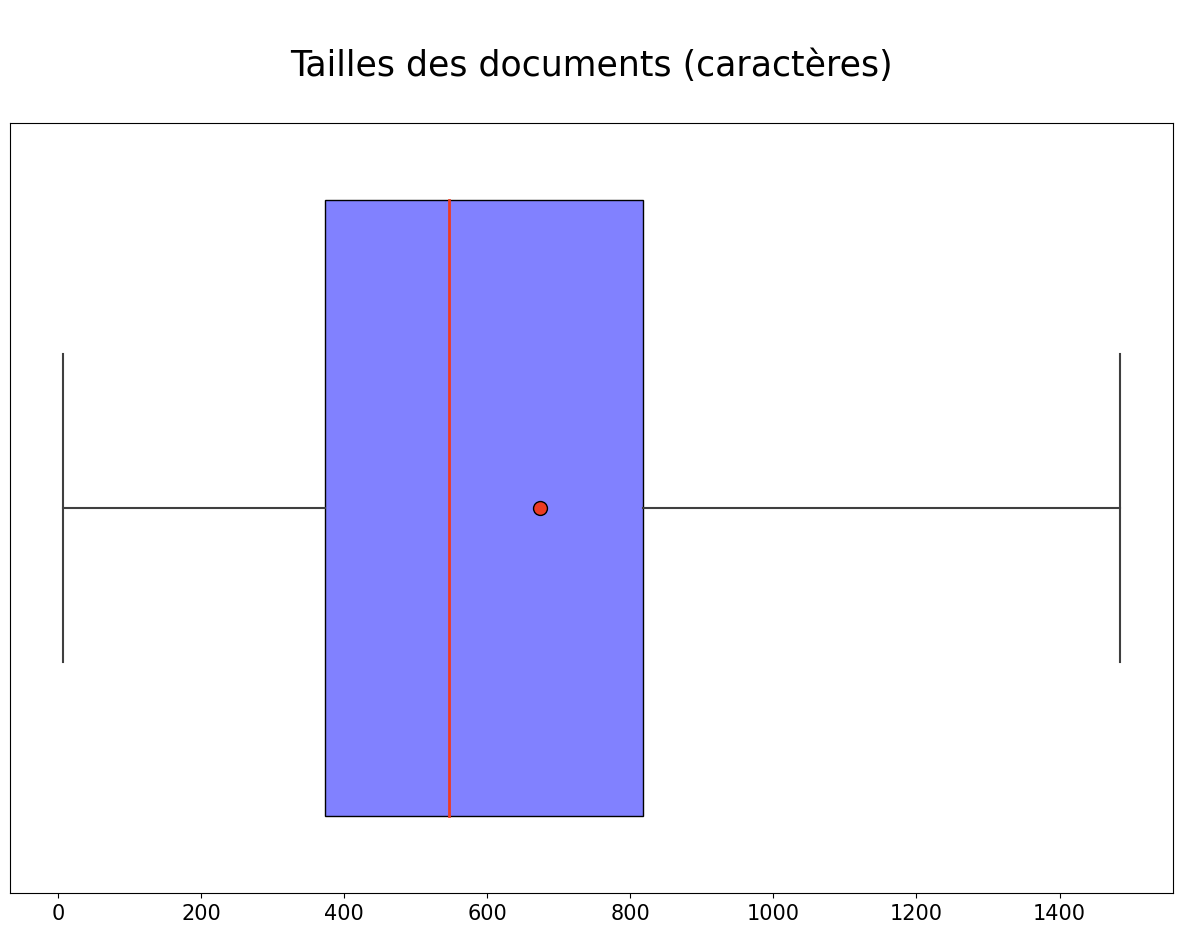

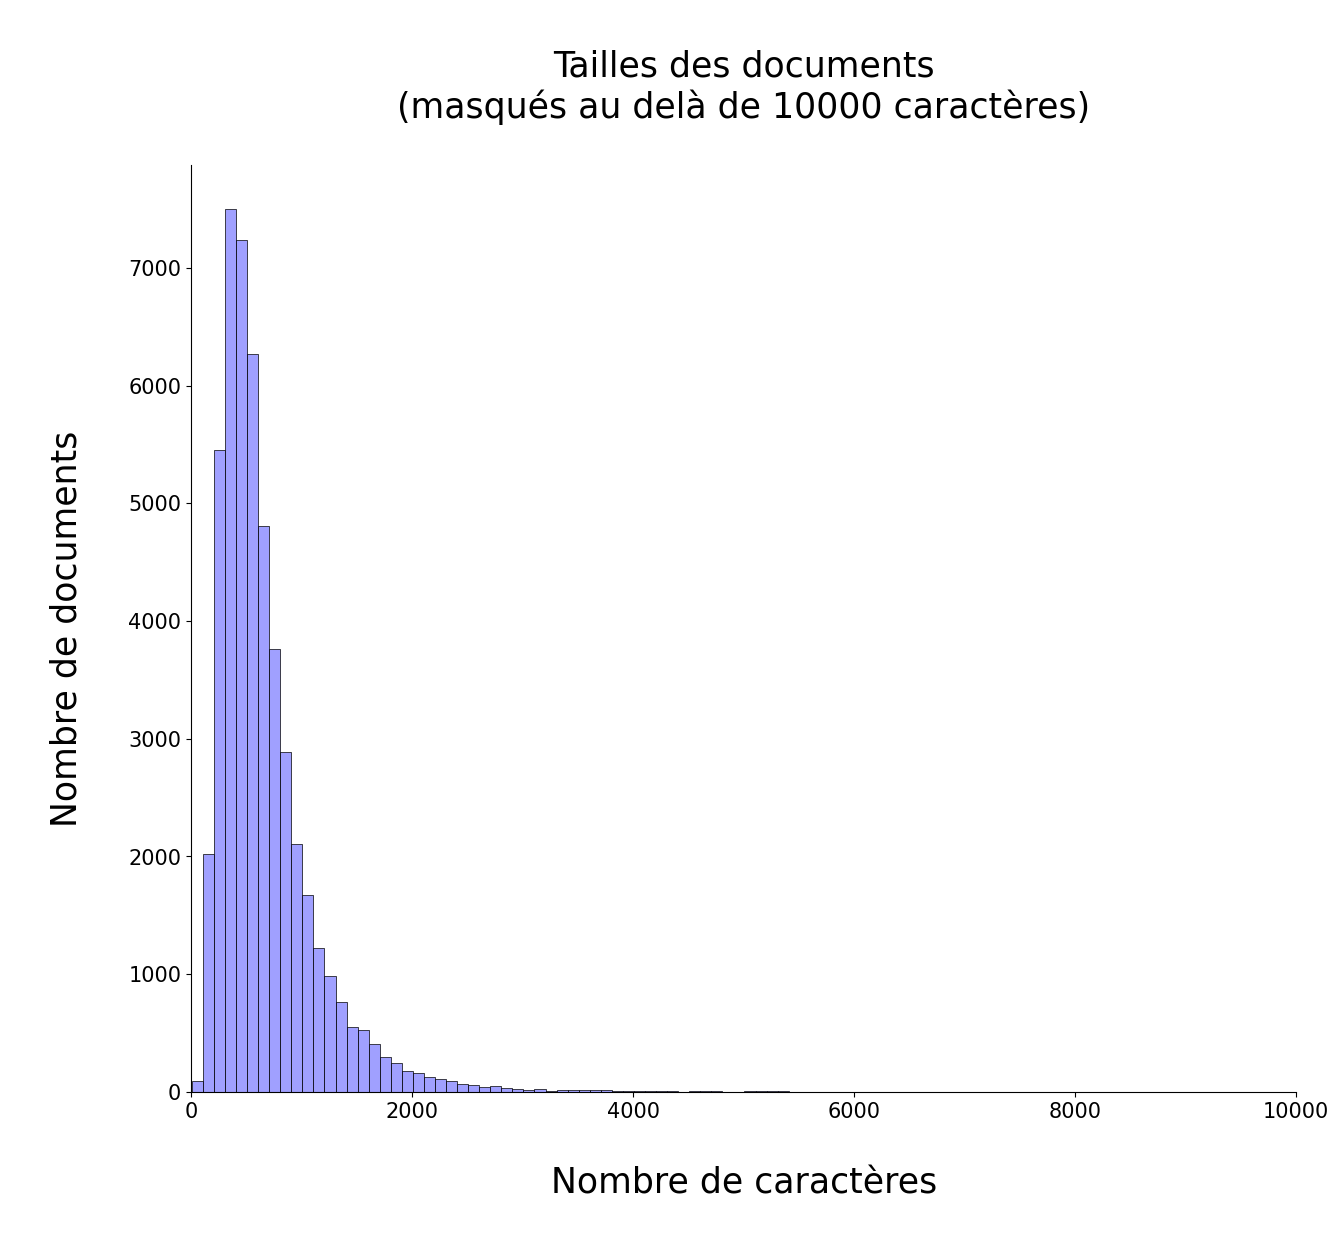

In [93]:
# Taille des documents : 

long_questions = data.corpus.str.len()

# Boîte à moustaches :

plt.figure(figsize=(15, 10))
sns.boxplot(long_questions,
            orient='h',
            showfliers=False,
            showmeans=True,
            **param_box_plot
    )
plt.yticks([])
plt.xticks(fontsize=15)
plt.title("\nTailles des documents (caractères)\n", fontsize=25)
plt.show()

# Displot : 

x_max = 10000
sns.displot(long_questions,
            binwidth=100,
            linewidth=0.5,
            **param_displot
    ).set(xlim=(0, x_max))
plt.yticks(fontsize=15)
plt.ylabel("\nNombre de documents\n", fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel("\nNombre de caractères\n", fontsize=25)
plt.title(f"\nTailles des documents\n(masqués au delà de {x_max} caractères)\n", fontsize=25)
plt.show()

- Nombre de tags : 

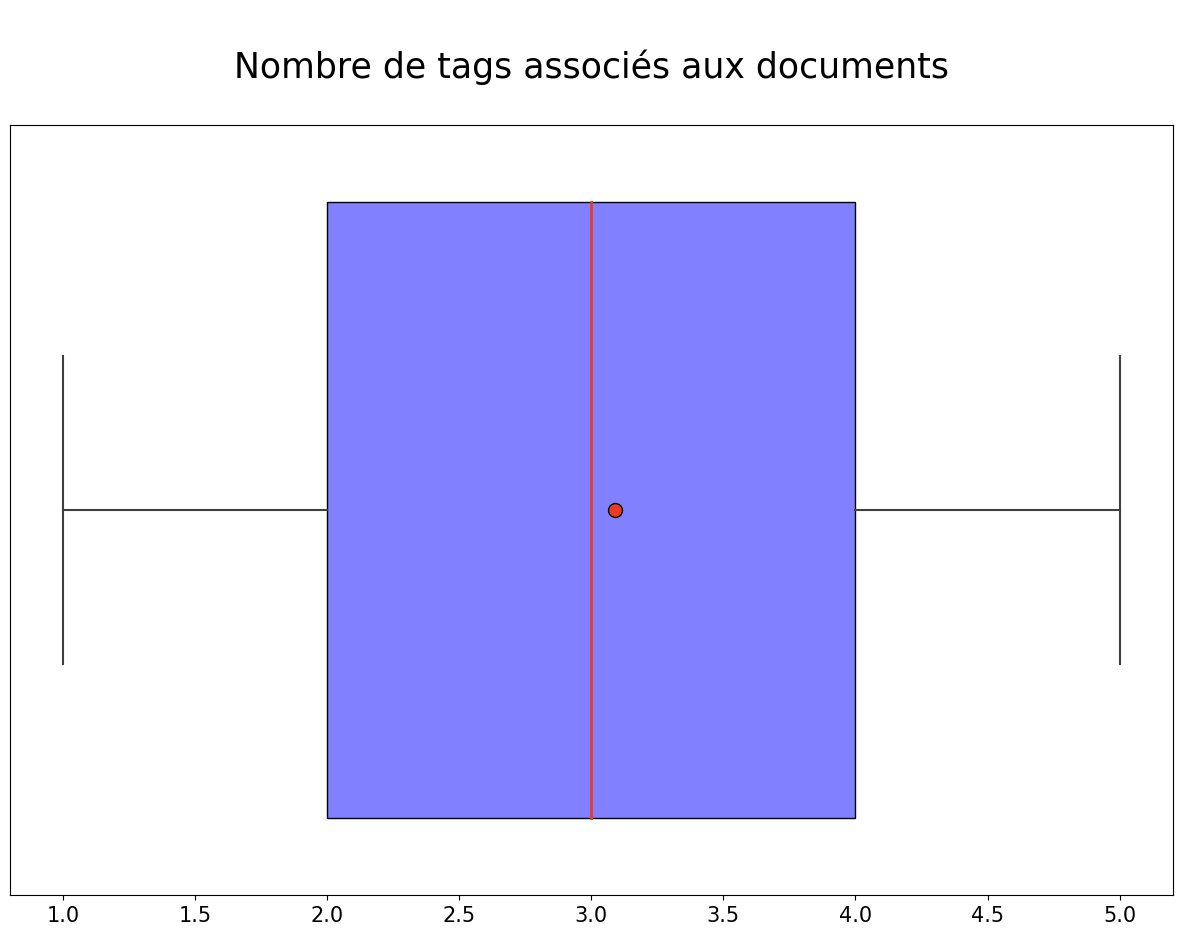

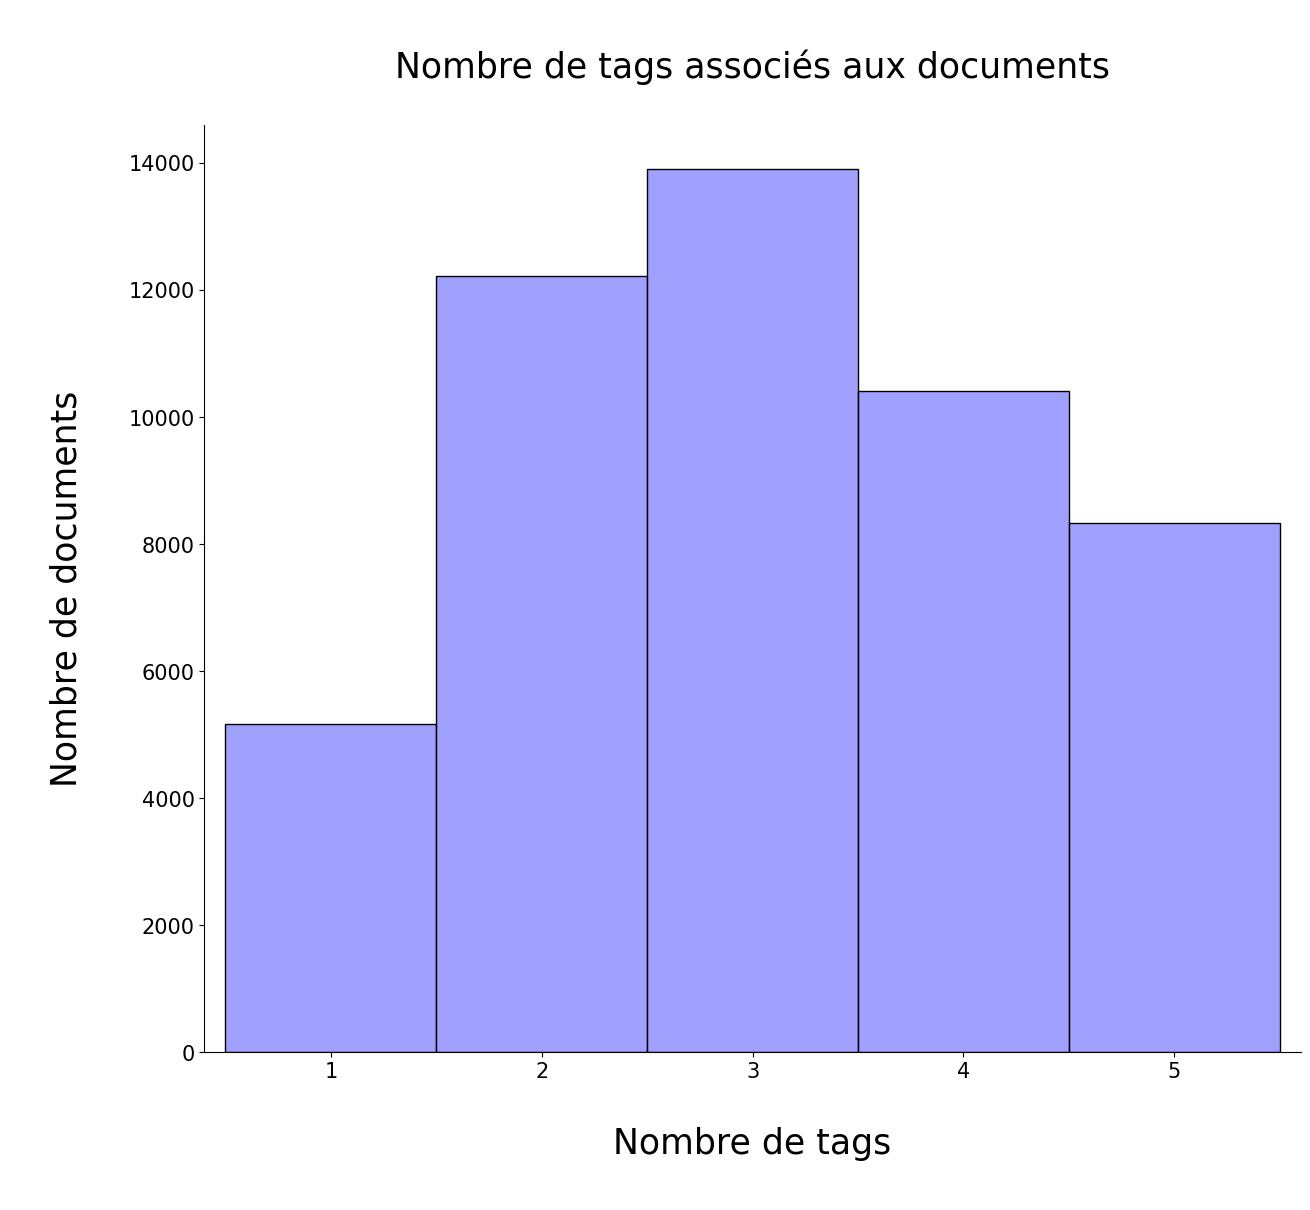

In [94]:
# Nombre de tags : 
nb_tags = data.tags.str.len()

# Boîte à moustaches :

plt.figure(figsize=(15, 10))
sns.boxplot(nb_tags,
            orient='h',
            showfliers=False,
            showmeans=True,
            **param_box_plot
    )
plt.yticks([])
plt.xticks(fontsize=15)
plt.title("\nNombre de tags associés aux documents\n", fontsize=25)
plt.show()

# Displot : 

sns.displot(nb_tags,
            binwidth=1,
            binrange=(0.5, 5.5),
            linewidth=1,
            **param_displot
    ).set(xlim=(0.4, 5.6))
plt.yticks(fontsize=15)
plt.ylabel("\nNombre de documents\n", fontsize=25)
plt.xticks(np.arange(min(nb_tags), max(nb_tags) + 1, step=1), fontsize=15)
plt.xlabel("\nNombre de tags\n", fontsize=25)
plt.title(f"\nNombre de tags associés aux documents\n", fontsize=25)
plt.show()

- Corrélations entre les valeurs numériques : 

In [95]:
# création de 2 nouvelles variables pour l'exploration

data['question_length'] = data.corpus.str.len()
data['tags_number'] = data.tags.str.len()

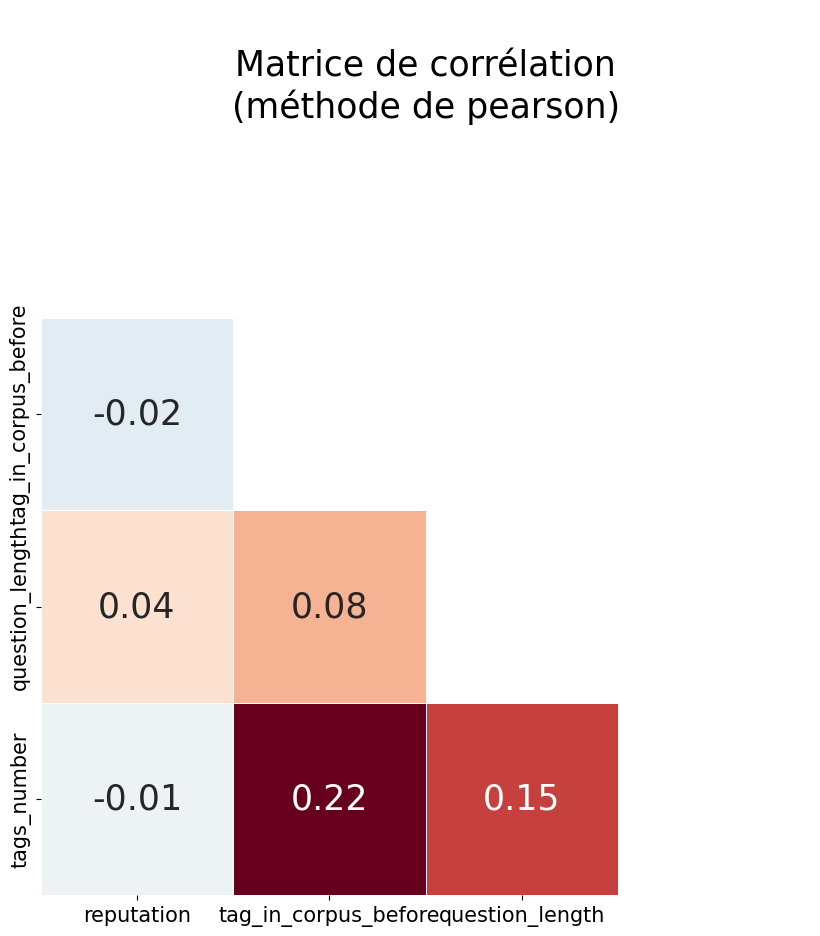

In [96]:
correlation = data.corr(numeric_only=True, method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool), 0)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    correlation,
    mask=mask,
    cbar=False,
    center=0,
    cmap='RdBu_r',
    annot=True,
    annot_kws={"size": 25},
    fmt='.2f',
    square=True,
    linewidths=0.5,
).set_title('\nMatrice de corrélation\n(méthode de pearson)', fontsize=25)

# Je masque la première étiquette de y
ax.yaxis.get_major_ticks()[0].set_visible(False)
# Je masque la dernière étiquette de x
ax.xaxis.get_major_ticks()[-1].set_visible(False)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)


plt.show()

- Taille des documents en fonction du nombre de tags : 

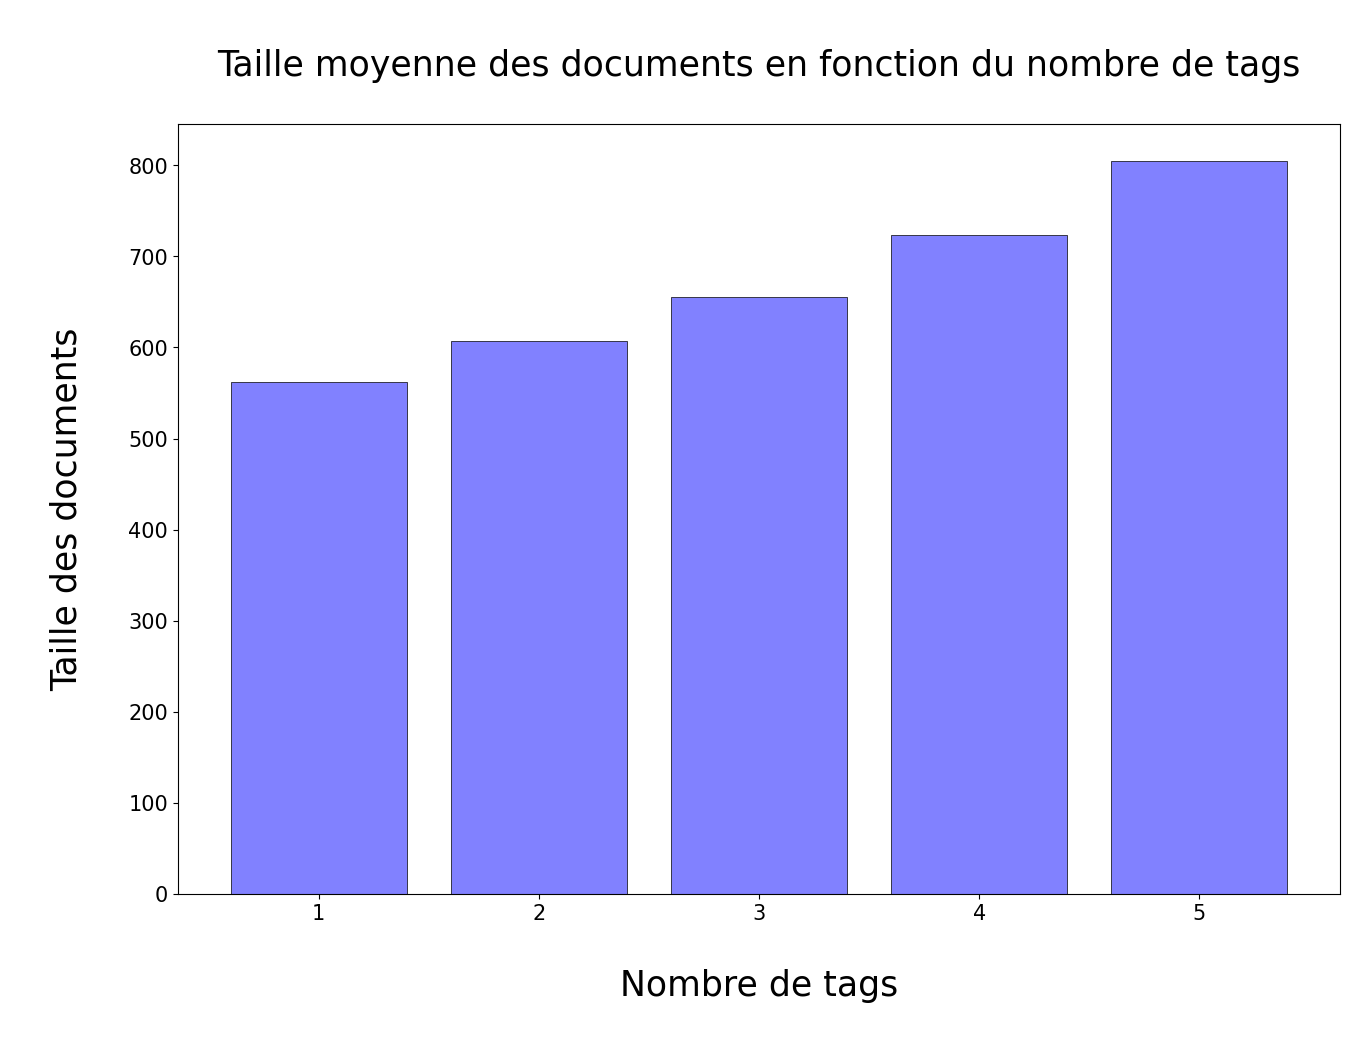

In [97]:
grouped_data = data[['question_length', 'tags_number']].groupby('tags_number').mean()

plt.figure(figsize=(15, 10))
plt.bar(grouped_data.index, grouped_data['question_length'], color='#8181FF', edgecolor='black', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("\nTaille des documents\n", fontsize=25)
plt.xlabel("\nNombre de tags\n", fontsize=25)
plt.title(f"\nTaille moyenne des documents en fonction du nombre de tags\n", fontsize=25)
plt.show()



- Réputations en fonction du nombre de tags : 

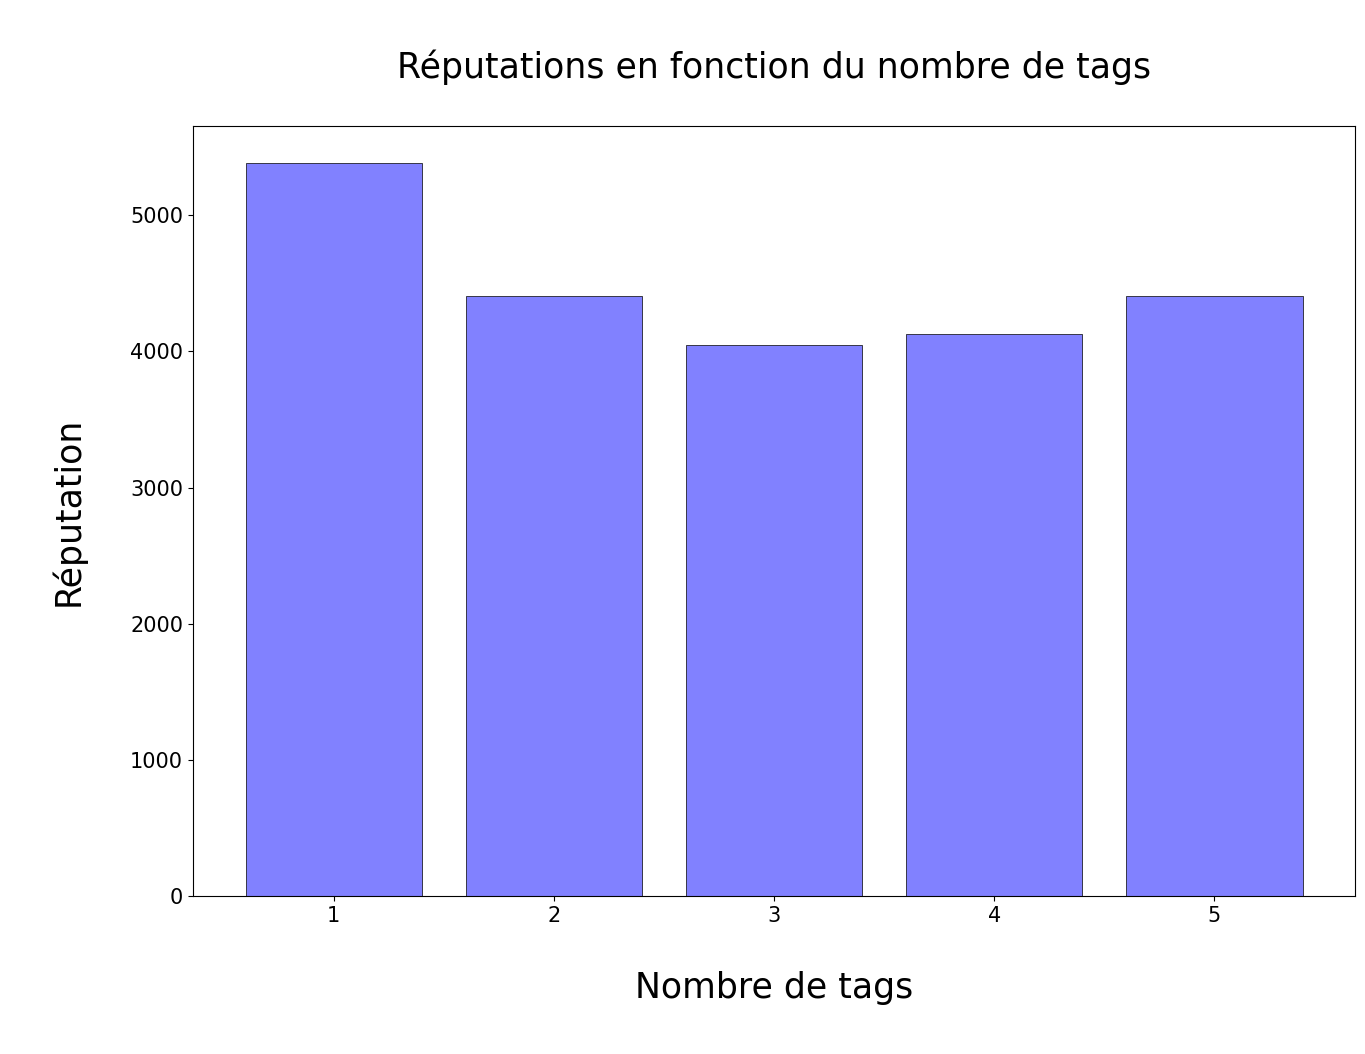

In [98]:
grouped_data = data[['reputation', 'tags_number']].groupby('tags_number').mean()

plt.figure(figsize=(15, 10))
plt.bar(grouped_data.index, grouped_data['reputation'], color='#8181FF', edgecolor='black', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("\nRéputation\n", fontsize=25)
plt.xlabel("\nNombre de tags\n", fontsize=25)
plt.title(f"\nRéputations en fonction du nombre de tags\n", fontsize=25)
plt.show()


### **Tags les plus fréquents**

Les 20 tags les plus présents : 

tags
python        7035
javascript    4671
c++           3018
c#            2984
reactjs       2492
r             2458
java          2280
typescript    2256
pandas        1664
android       1450
html          1349
flutter       1324
css           1227
node.js       1197
c             1138
sql           1095
dataframe      986
php            955
swift          927
python-3.x     920
Name: count, dtype: int64
--------------------------------------------------
154513 tags ont été utilisés pour décrire l'ensemble des documents.
Il y a 13389 tags différents.
--------------------------------------------------


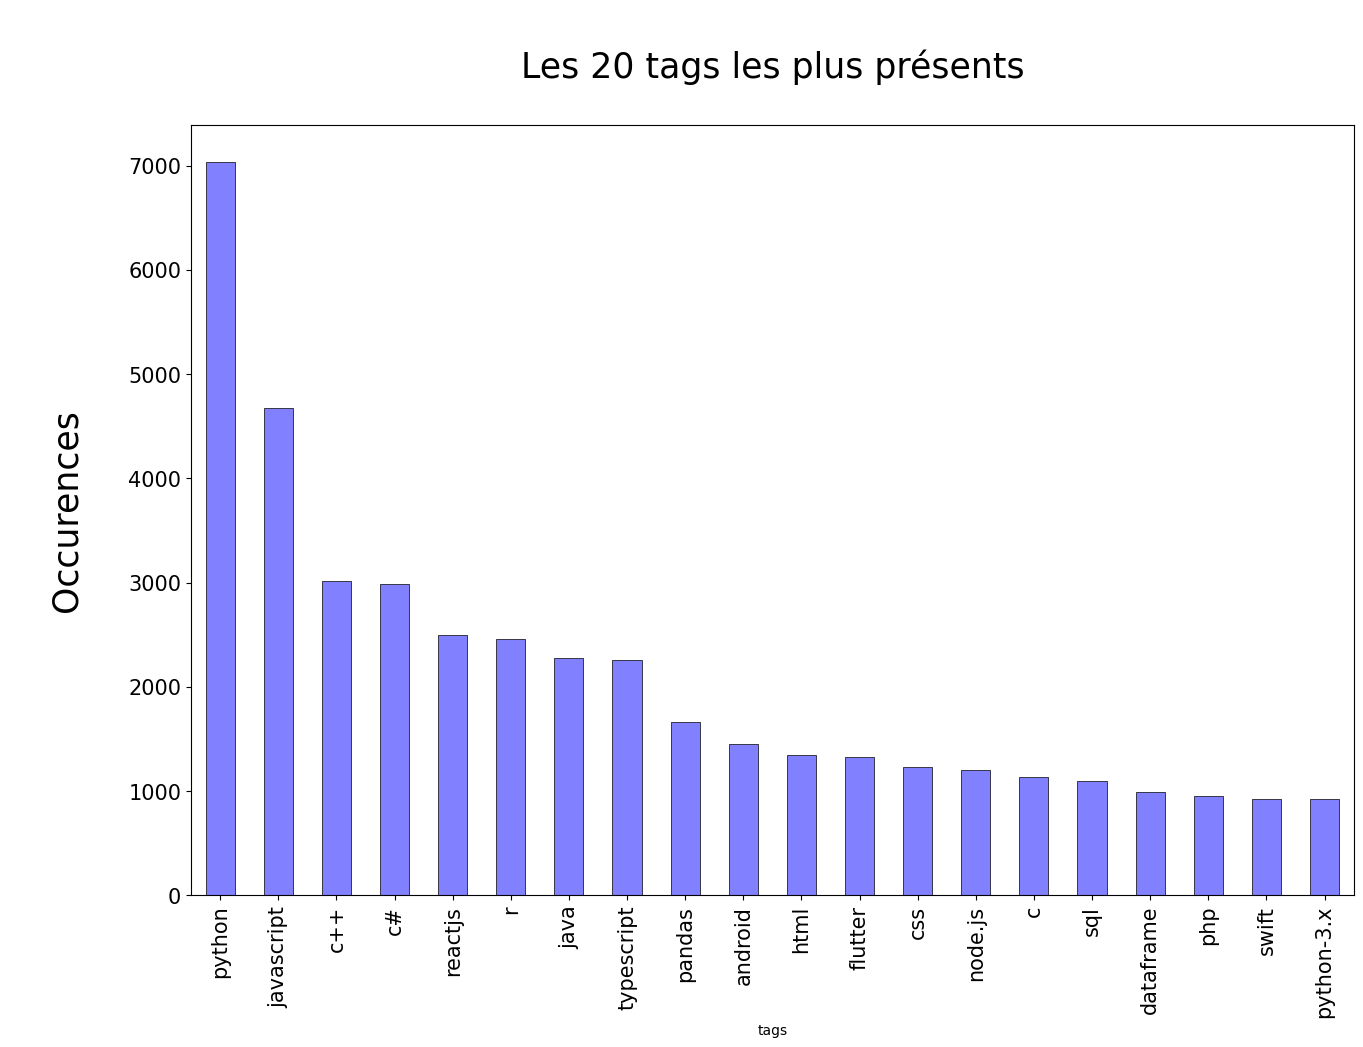

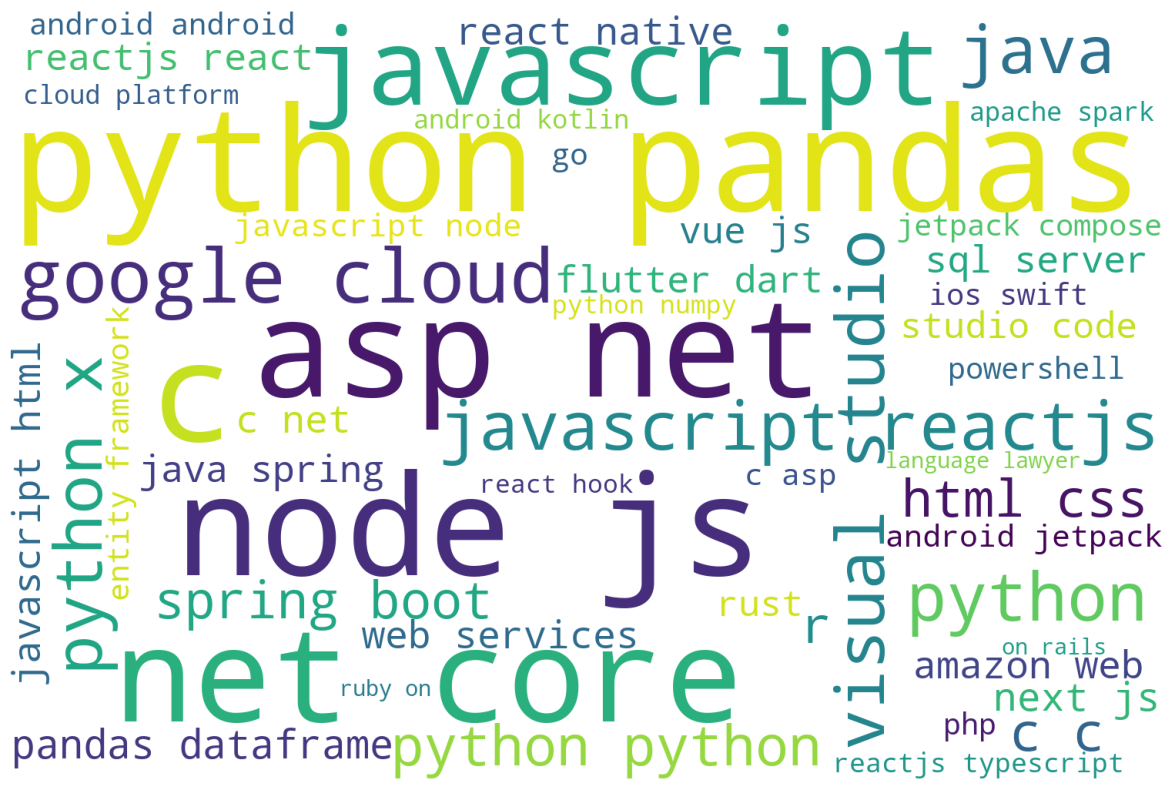

In [99]:
all_tags = data['tags'].explode()
top_tags = 20

print(f"Les {top_tags} tags les plus présents : \n")
print(all_tags.value_counts().head(top_tags))
print("-"*50)
print(f"{len(all_tags)} tags ont été utilisés pour décrire l'ensemble des documents.")
print(f"Il y a {len(all_tags.unique())} tags différents.")
print("-"*50)

# Bar plot
plt.figure(figsize=(15, 10))
all_tags.value_counts().head(top_tags).plot.bar(color='#8181FF', edgecolor='black', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("\nOccurences\n", fontsize=25)
plt.title(f"\nLes {top_tags} tags les plus présents\n", fontsize=25)
plt.show()

# Words cloud
plt.figure(figsize=(15, 10))  # On dimentionne l'image à 15*10 pouces,
                              # donc avec le dpi par défaut de 100, cela donne 1500*1000px

tags_cloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50,
                      width=1500,  # Dimention en px de l'image à faire entrer 
                      height=1000  # dans la figure plt de 15*10 pouces
                      ).generate(" ".join(all_tags))

plt.imshow(tags_cloud)
plt.axis("off")
plt.show()


- Exemples de documents avec leur tags : 

In [100]:
for idx, ser in data.sample(3).iterrows():
    txt_1 = f"Tags : {ser['tags']}\n\n"
    print(txt_1 + ser['corpus'])
    print("-"*50, "\n")

Tags : ['python', 'tkinter', 'lambda']

tkinter: passing event arguments and additional arguments to an event handler function I would like to pass both event and an additional argument to a handler function.
The purpose of this is to display a context menu using the  and  arguments of the event object.
I have tried the two techniques shown below. For simplicity, I prefer the one that uses the lambda function, but it doesn't work.
Is it possible to fix it? Any idea or explanation?


-------------------------------------------------- 

Tags : ['google-cloud-platform', 'network-programming', 'load-balancing', 'gcp-load-balancer']

GCP: load balancer rewrite path I'm setting up traffic management for a global external HTTP(S) load balancers. I have two backend Cloud Run services,  and , that I want to serve from the same IP/domain.
I want to configure them like this:
 -> 
 -> 
I can use the simple routing rules to serve traffic semi-expected:




path
backend




/*
serverless-lb-www-serv

## **Text processing**

### **Commençons par analyser le corpus dans sa globalité**

- Fonctions de base : 

In [101]:
def display_tokens_infos(tokens):
    """Infos de base d'un corpus"""

    print(f"Nombre de tokens : {len(tokens)}\nNombre de tokens uniques : {len(set(tokens))}")
    print(f"5 premiers tokens : {tokens[:5].values}")

In [102]:
def basic_cleaning(doc, suppr_doublons=False):
    """Cleaning de base
    
    suppr_doublons : va supprimer les tokens en double dans chaque documents (par défaut : False)
    """

    # Passage en minuscule
    doc = doc.lower().strip()  # .strip() enlève le/les caractère(s) définis à gauche et à droite (espace par défaut)

    # Tokenisation avec NLTK
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Suppression des stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Suppression des caractères numériques
    alpha_tokens = [w for w in cleaned_tokens_list if w.isalpha()]

    if suppr_doublons:
        final = list(set(alpha_tokens))
    else:
        final = alpha_tokens
   
    return final

- Définition des stopwords que l'on va utiliser : 

In [103]:
stop_words = set(stopwords.words('english'))

- Traitement préliminaire : suppression des occurences locales.

<div class="alert alert-info">
Avant de créer un corpus global avec tous les documents, il est important de réaliser une étape préliminaire : tokeniser chaque document et supprimer les doublons dans ces derniers. De cette manière, au moment de déterminer la liste des mots rares (apparaissant moins d'un certain nombre de fois dans tout le corpus), nous ne seront plus biaisés par les occurences locales. Ces occurences locales peuvent être importantes, par exemple avec des noms de variables spécifiques à un code présent dans un seul document.
</div>

In [104]:
data['preprocessed_corpus'] = data.corpus.apply(basic_cleaning, suppr_doublons=True)

- Création d'un corpus global en fusionnant toutes les données de la colonne ```data['preprocessed_corpus']``` : 

In [105]:
corpus = data['preprocessed_corpus'].explode()

- Distribution des tokens : 

In [106]:
display_tokens_infos(corpus)

print("Tokens les plus fréquents : ")
display(corpus.value_counts().head(10))

print("Tokens les moins fréquents : ")
display(corpus.value_counts().tail(10))

print("Distribution des présences des tokens : ")
display(corpus.value_counts().describe())


Nombre de tokens : 2092424
Nombre de tokens uniques : 59353
5 premiers tokens : ['ok' 'clear' 'end' 'state' 'lexer']
Tokens les plus fréquents : 


preprocessed_corpus
using        18772
like         17784
code         17313
get          13649
want         13423
use          13247
would        11732
error        11583
way          11263
following    11071
Name: count, dtype: int64

Tokens les moins fréquents : 


preprocessed_corpus
onbind           1
emailpassword    1
futureor         1
emaillogin       1
getemail         1
resumedata       1
frederikhors     1
analyis          1
loopify          1
ioption          1
Name: count, dtype: int64

Distribution des présences des tokens : 


count    59353.000000
mean        35.253888
std        308.646718
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      18772.000000
Name: count, dtype: float64

La distribution est très asymétrique : 50% des tokens sont présents 1 seule fois.

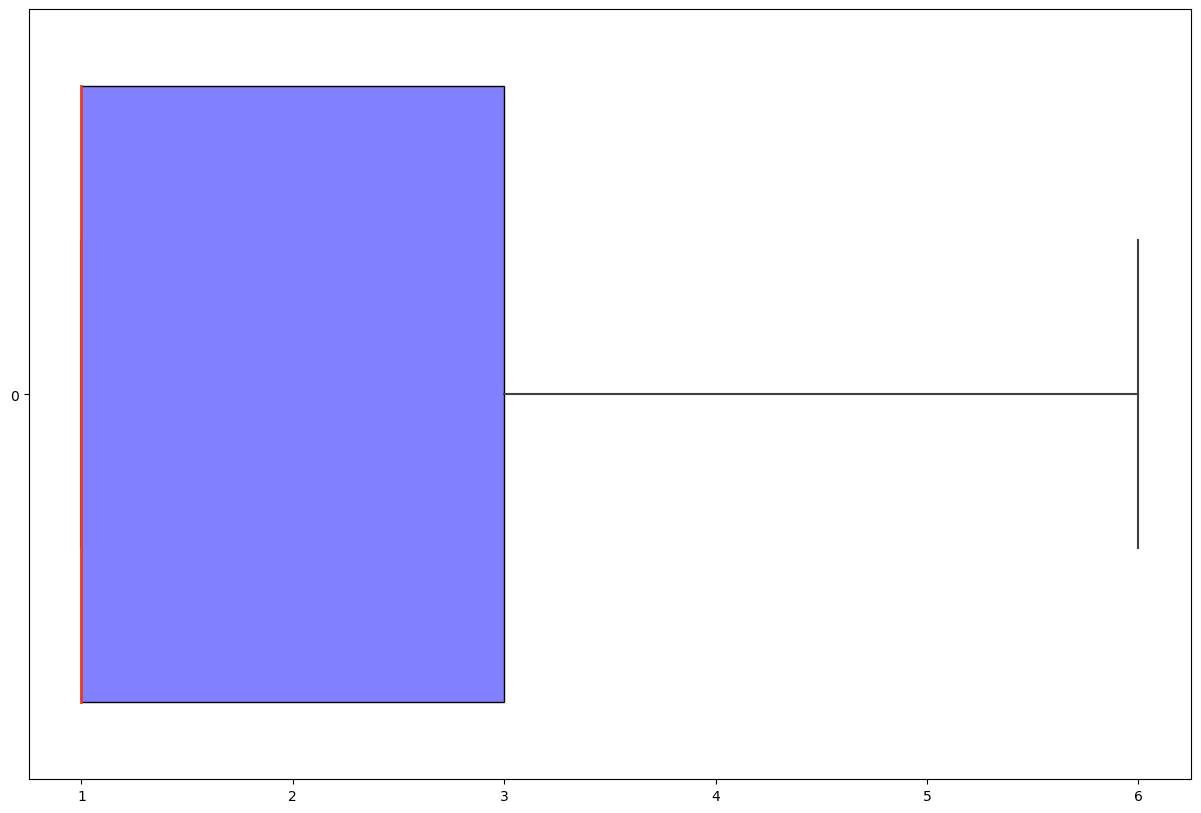

In [107]:
plt.figure(figsize=(15, 10))
sns.boxplot(corpus.value_counts(), orient='h', showfliers=False, showmeans=False, **param_box_plot);


- Mots rares : <br>

Pour un mot unique, il y a de grandes chances soit qu'il soit éliminé lors de méthodes de réduction de dimentionnalité, soit qu'il ne puisse pas être utilisé comme dimention.<br>
Et pour accélérer nos calculs futurs, on a tout intérêt à diminuer la liste de tokens de notre corpus et donc à supprimer les tokens présents une seule fois.

In [108]:
list_unique_words = corpus.value_counts()[corpus.value_counts()==1]
list_unique_words = list(list_unique_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots rares : {len(list_unique_words)}")
print(f"Exemples de mots rares : {list_unique_words[:10]}")

Nombre de mots rares : 35530
Exemples de mots rares : ['gradiente', 'harnesses', 'trackingid', 'proliferating', 'shapeley', 'lispy', 'bls', 'subscriptionname', 'moviedetailcontainer', 'safetensors']


- Mots présents 5 fois ou moins : 

On peut faire de même avec les mots présents 5 fois ou moins.

In [109]:
list_min_5_words = corpus.value_counts()[corpus.value_counts()<=5]
list_min_5_words = list(list_min_5_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 5 fois ou moins : {len(list_min_5_words)}")
print(f"Exemples de mots : {list_min_5_words[:10]}")

Nombre de mots présents 5 fois ou moins : 47646
Exemples de mots : ['sould', 'redmi', 'selectbox', 'underlyingerror', 'interopservices', 'grounds', 'california', 'combinatorial', 'revolve', 'codelab']


Il y en a bien plus.

- Mots présents 10 fois ou moins : 

In [110]:
list_min_10_words = corpus.value_counts()[corpus.value_counts()<=10]
list_min_10_words = list(list_min_10_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 10 fois ou moins : {len(list_min_10_words)}")
print(f"Exemples de mots : {list_min_10_words[:10]}")

Nombre de mots présents 10 fois ou moins : 50810
Exemples de mots : ['citing', 'turborepo', 'colons', 'wow', 'browsed', 'lastest', 'wished', 'diverge', 'securityconfig', 'adhere']


Il y en a encore plus, mais l'augmentation est beaucoup moins forte qu'en passant de 1 à 5. Nous n'irons pas plus loin que 10.

### **Lemmatisation : comparaison de NLTK et SpaCy**

- Exemple de phrase à lemmatiser : 

In [111]:
phrase = "These are sentences going to be translated"
tokenizer = RegexpTokenizer(r"\w+")
phrase_tokens = tokenizer.tokenize(phrase)

- Lemmatisation avec NLTK : 

In [112]:
# Instanciation
wordNetLemmatizer = WordNetLemmatizer()

debut = time.time()  # Heure de début du traitement
lemmaWords1 = [wordNetLemmatizer.lemmatize(word) for word in phrase_tokens]
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f'Tokens après lemmatisation avec WordNet Lemmatizer (NLTK) : \n{phrase} => {lemmaWords1}')

Durée du traitement : 0.00 s
Tokens après lemmatisation avec WordNet Lemmatizer (NLTK) : 
These are sentences going to be translated => ['These', 'are', 'sentence', 'going', 'to', 'be', 'translated']


- Lemmatisation avec SpaCy : 

In [113]:
# Instanciation
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' ne sont pas utiles ici

debut = time.time()  # Heure de début du traitement
doc = spacy_nlp(phrase)
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

lemmaWords2 = [word.lemma_ for word in doc]
print(f'Tokens après lemmatisation avec SpaCy : \n{phrase} => {lemmaWords2}')

Durée du traitement : 0.01 s
Tokens après lemmatisation avec SpaCy : 
These are sentences going to be translated => ['these', 'be', 'sentence', 'go', 'to', 'be', 'translate']


- Comparaison des deux résultats : 

In [114]:
print(phrase, "(Texte à lemmatiser)")
print(lemmaWords1, "(NLTK)")
print(lemmaWords2, "(SpaCy)")

These are sentences going to be translated (Texte à lemmatiser)
['These', 'are', 'sentence', 'going', 'to', 'be', 'translated'] (NLTK)
['these', 'be', 'sentence', 'go', 'to', 'be', 'translate'] (SpaCy)


NLTK a juste mis *sentences* au singulier, alors que SpaCy a en plus donné la racine des mots *are*, *going* et *translated*.<br>
Le lemmatiseur de SpaCy semble plus efficace, c'est celui-ci que nous utiliserons.

### **Traitement des documents du corpus**

Voici les traitements que nous allons appliquer aux documents de *```data['corpus']```* : <br>

- Passer tous le texte en minuscule, afin de pouvoir regrouper les mots écrits avec des casses différentes.
- Exclure les mots rares, ceux qui sont présents 10 fois ou moins dans tout le corpus.
- Retrait des *Stop Words*, mots commun ayant peu d'intérêt dans le sens global des documents.
- Suppression des mots courts. Les mots très courts ne sont généralement pas ceux qui apportent le plus de sens.
- Suppression des données numériques. Elles ne nous intéressent pas ici.
- Lemmatisation. Afin de réduire la taille du vocabulaire, nous allons regrouper les déclinaisons d'un même mot en sa racine.
- POS (part-of-speech) : nous n'allons garder que les catégories de mots les plus pertinentes.




- Création de la fonction de traitement des documents : 

In [115]:
def process_documents(doc,
                   tokenizer=None,
                   pos=None,
                   lemmentizer=None,
                   rejoin=False,
                   stop_words=None,
                   list_rare_words=None,
                   min_len_word=3,
                   min_len_word_except=[],
                   alpha_only=True,
                   extra_words=None,
                   return_set=False
                   ):
    
    """
    Cette fonction permet de tokéniser un texte et d'en réduire la dimension.
    Elle est conçue pour fonctionner avec SpaCy

    ------------------------------------

    Arguments positionnels : 

    doc : le document (texte au format str) à traiter.

    ------------------------------------

    Arguments optionnels : 

    tokenizer (obj) : l'instance du tokenizer à utiliser (par défaut : None).
    lemmentizer (obj) : l'instance du lemmentizer à utiliser (par défaut : None).
    pos (liste) : liste contenant les catégories grammaticales de mot à conserver à l'étape de lemmatisation (par défaut : None).
    rejoin (bool) : si True, retourne une unique chaine de caractère contenant les tokens séparés par un espace (par défaut : False).
    stop_words (set) : liste des stop words à utiliser, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    list_rare_words (set) : liste de mots rares à retirer, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    min_len_word (int) : longueur des mots courts à supprimer, si None aucun mot supprimé (par défaut : 3).
    min_len_word_except (liste) : mots à conserver même si leur taille est inférieure à min_len_word (par défaut : liste vide []).
    alpha_only (bool) : utilisation de la méthode .isalpha() pour ne garder que les lettres (par défaur : True).
    extra_words (set) : mots spécifiques supplémentaire à supprimer, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    return_set (bool) : retourner les résultats sous forme de set, pour supprimer les doublons dans les documents (Par défaut : False).

    ------------------------------------

    Renvoie :

    Un string (si join est True) ou un set de tokens.

    """

    # Passage du texte en minuscules
    doc = doc.lower()

    # Tokenisation du texte
    if tokenizer:
        raw_tokens_list = tokenizer.tokenize(doc)
    else:
        raw_tokens_list = doc

    # S'il est choisi de retourner un set, alors nous pouvons dès maintenant
    # supprimer les doublons, les traitements suivants seront plus rapides
    if return_set:
        raw_tokens_list = set(raw_tokens_list)

    # Suppression des stopwords (si fournis)
    if stop_words:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    else:
        cleaned_tokens_list = raw_tokens_list

    # Suppression des mots rares (si fournis)
    if list_rare_words:
        non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    else:
        non_rare_tokens = cleaned_tokens_list

    # Suppression des mots courts (si l'option est activée)
    if not min_len_word:
        more_than_N = non_rare_tokens
    else:
        more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word or w in min_len_word_except]

    # Suppression des caractères numériques (si l'option est activée)
    if alpha_only:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]  # isalpha() sert à retourner True s'il n'y a que des lettres, pas de chiffre
    else:
        alpha_tokens = more_than_N

    # Lemmatisation
    if lemmentizer:
        ecrase = ' '.join(alpha_tokens)  # Il faut "écraser" la liste pour qu'elle puisse passer dans le lemmatizerde Spacy
        doc = lemmentizer(ecrase)
        if pos:
            lemmatized = [word.lemma_ for word in doc if word.pos_ in pos]
        else:
            lemmatized = [word.lemma_ for word in doc]
    else:
        lemmatized = alpha_tokens

    # S'il est choisi de retourner un set, alors nous pouvons dès maintenant
    # supprimer les doublons, les traitements suivants seront plus rapides
    if return_set:
        lemmatized = set(lemmatized)

    # Suppression des extra_words (si fournis)
    if extra_words:
        final = [w for w in lemmatized if w not in extra_words]
    else:
        final = lemmatized

    # Forme des données retournées
    if rejoin:
        final = " ".join(final) # retourne une unique chaine de caractère contenant les tokens séparés par un espace
    
    if return_set:
        return set(final)
    else:
        return final

Préparation des différent éléments nécéssaire aux traitement : <br>
- Instanciation du Tokenizer, nous allons utiliser *RegexpTokenizer* de NLTK.
- Instanciation du Lemmentiseur, nous allons utiliser celui de SpaCy.
- Définition des mots rares, nous allons utiliser ceux apparaissant 10 fois ou moins dans tout le corpus.
- Définition des catégories de mots à conserver, nous allons garder les noms.

In [116]:
# Instanciation du tokenizer
tokenizer = RegexpTokenizer(r"\w+")

# Instanciation du lemmentizer, on désactive les composants dont on a pas besoin
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

# Convertion de la liste de mots rares en set, ce qui va considérablement réduire les temps de calculs
mots_rares = set(list_min_10_words)

# Catégories de mots à garder à l'étape de lemmatisation
pos_a_garder = set([
             #  "ADJ",  # "adjective"
             #  "ADP",  # "adposition"
             #  "ADV",  # "adverb"
             #  "AUX",  # "auxiliary"
             #  "CONJ",  # "conjunction"
             #  "CCONJ",  # "coordinating conjunction"
             #  "DET",  # "determiner"
             #  "INTJ",  # "interjection"
                "NOUN",  # "noun"
             #  "NUM",  # "numeral"
             #  "PART",  # "particle"
             #  "PRON",  # "pronoun"
             #  "PROPN",  # "proper noun"
             #  "PUNCT",  # "punctuation"
             #  "SCONJ",  # "subordinating conjunction"
             #  "SYM",  # "symbol"
             #  "VERB",  # "verb"
             #  "X",  # "other"
             #  "EOL",  # "end of line"
             #  "SPACE",  # "space"
])

- Traitement du corpus : 

In [117]:
debut = time.time()  # Heure de début du traitement
data['processed_corpus'] = data.corpus.apply(process_documents,
                                   doc,
                                   tokenizer=tokenizer,
                                   pos=pos_a_garder,
                                   lemmentizer=spacy_nlp,
                                   rejoin=False,
                                   stop_words=stop_words,
                                   list_rare_words=mots_rares,
                                   min_len_word=3,
                                   min_len_word_except=['c', 'r'],  # "c" et "r" peuvent faire référence aux langages de programmation
                                   alpha_only=True,
                                   extra_words=None,
                                   return_set=False
                             )
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

data

Durée du traitement : 204.91 s


,creationdate,tags,reputation,corpus,tag_in_corpus_before,question_length,tags_number,preprocessed_corpus,processed_corpus
0,2022-05-08 20:40:40,[antlr4],129,Lexer rule to handle escape of quote with quot...,False,1529,1,"[ok, clear, end, state, lexer, n, consuming, s...","[rule, handle, backslash, expand, answer, esca..."
1,2022-05-08 21:22:05,"[reactjs, firebase, jestjs]",121,"Firebase - Testing with Jest throws error ""INT...",False,476,3,"[test, works, fine, header, error, pages, sign...","[firebase, testing, jest, error, assertion, cl..."
2,2022-05-08 21:49:08,"[async-await, concurrency, hacklang]",307,Concurrent block in hacklang Since hack is a s...,True,194,3,"[concurrent, benefit, block, hack, waiting, si...","[block, hack, language, benefit, block, job, w..."
3,2022-05-08 21:49:57,[typescript],1436,Can you set a type for a function in typescrip...,True,747,1,"[required, implement, ide, quickly, thing, lin...","[type, function, typescript, function, type, i..."
4,2022-05-08 21:51:00,"[expo, google-play-console, google-play-develo...",4346,"Expo EAS Submit, where to store service accoun...",True,553,3,"[required, path, prompted, submitted, somehow,...","[store, service, account, looking, eas, expo, ..."
...,...,...,...,...,...,...,...,...,...
49995,2022-03-21 09:01:04,"[ionic-framework, ionic-react]",590,Ionic-React App Automatically Changing to Dark...,True,481,2,"[clear, apk, goes, light, works, onwards, with...","[app, mode, react, app, behaviour, building, a..."
49996,2022-03-21 09:02:39,[stripe-payments],125,is it possible to operate two service in the o...,False,307,1,"[legal, registered, corporation, two, domain, ...","[service, stripe, account, service, service, d..."
49997,2022-03-21 09:02:54,[terraform],4200,Which security problem does terraform Checksum...,True,553,1,"[vicious, field, security, problem, intended, ...","[security, problem, terraform, dependency, loc..."
49998,2022-03-21 13:54:21,"[azure, azurite]",135,Visual studio 2022 with azurite integrated (v3...,True,1037,2,"[thrown, read, incoming, studio, delivered, in...","[studio, creation, blob, container, error, mes..."


- Les traitements ont-ils engendré des valeurs manquantes ?

In [118]:
# Ici on cherche des listes vides [] et non des NaN
print(f"Il y a {data.loc[data['processed_corpus'].apply(len) == 0].shape[0]} lignes sans aucun token suite au traitement précédent.")

Il y a 9 lignes sans aucun token suite au traitement précédent.


- Suppression des lignes qui n'ont pas de token dans *processed_corpus* : 

In [119]:
# Suppression des lignes sans token et reset de l'index
data = data.loc[data['processed_corpus'].apply(len) > 0]

### **Post traitement**

Lors des traitements, les mots rares du corpus original ont été supprimés.<br>
Cependant, les traitements, vraisemblablement l'étape du POS, ont fait apparaitre de nouveaux mots rares, qu'il va falloir supprimer également.<br>

In [120]:
# On regroupe les tokens de tous les documents dans un pd.series
processed_corpus = data['processed_corpus'].explode()

post_list_min_10_words = processed_corpus.value_counts()[processed_corpus.value_counts()<=10]
post_list_min_10_words = list(post_list_min_10_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 10 fois ou moins : {len(post_list_min_10_words)}")
print(f"Exemples de mots : {post_list_min_10_words[:10]}")

Nombre de mots présents 10 fois ou moins : 1309
Exemples de mots : ['disregard', 'esm', 'nlp', 'concurrent', 'homework', 'cosmo', 'dataproc', 'firing', 'intersect', 'keyof']


- Définition de la fonction de suppression des mots rares post traitement : 

In [121]:
def post_rare_suppr(doc,
                    post_rare_words=None
                   ):
        # Suppression des mots rares (si fournis)
    if post_rare_words:
        non_rare_tokens = [w for w in doc if w not in post_rare_words]
    else:
        non_rare_tokens = doc
    return non_rare_tokens

- Transformation de la liste de mots rares en set pour un traitement plus rapide : 

In [122]:
post_list_min_10_words = set(post_list_min_10_words)

- Suppression des nouveaux mots rares : 

In [123]:
data['processed_corpus'] = data.processed_corpus.apply(post_rare_suppr, post_rare_words=post_list_min_10_words)

### **Comparaison du corpus d'origine avec le corpus traitré**

- Corpus d'origine qu'on avait créé précédemment (tokenisé, sans stop words et sans nombre) : 

In [124]:
display_tokens_infos(corpus)

print()

print("Tokens les plus fréquents : ")
display(corpus.value_counts().head(10))

print("Tokens les moins fréquents : ")
display(corpus.value_counts().tail(10))

print("Distribution des présences des tokens : ")
display(corpus.value_counts().describe())

Nombre de tokens : 2092424
Nombre de tokens uniques : 59353
5 premiers tokens : ['ok' 'clear' 'end' 'state' 'lexer']

Tokens les plus fréquents : 


preprocessed_corpus
using        18772
like         17784
code         17313
get          13649
want         13423
use          13247
would        11732
error        11583
way          11263
following    11071
Name: count, dtype: int64

Tokens les moins fréquents : 


preprocessed_corpus
onbind           1
emailpassword    1
futureor         1
emaillogin       1
getemail         1
resumedata       1
frederikhors     1
analyis          1
loopify          1
ioption          1
Name: count, dtype: int64

Distribution des présences des tokens : 


count    59353.000000
mean        35.253888
std        308.646718
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      18772.000000
Name: count, dtype: float64

### **Word cloud du corpus d'origine**

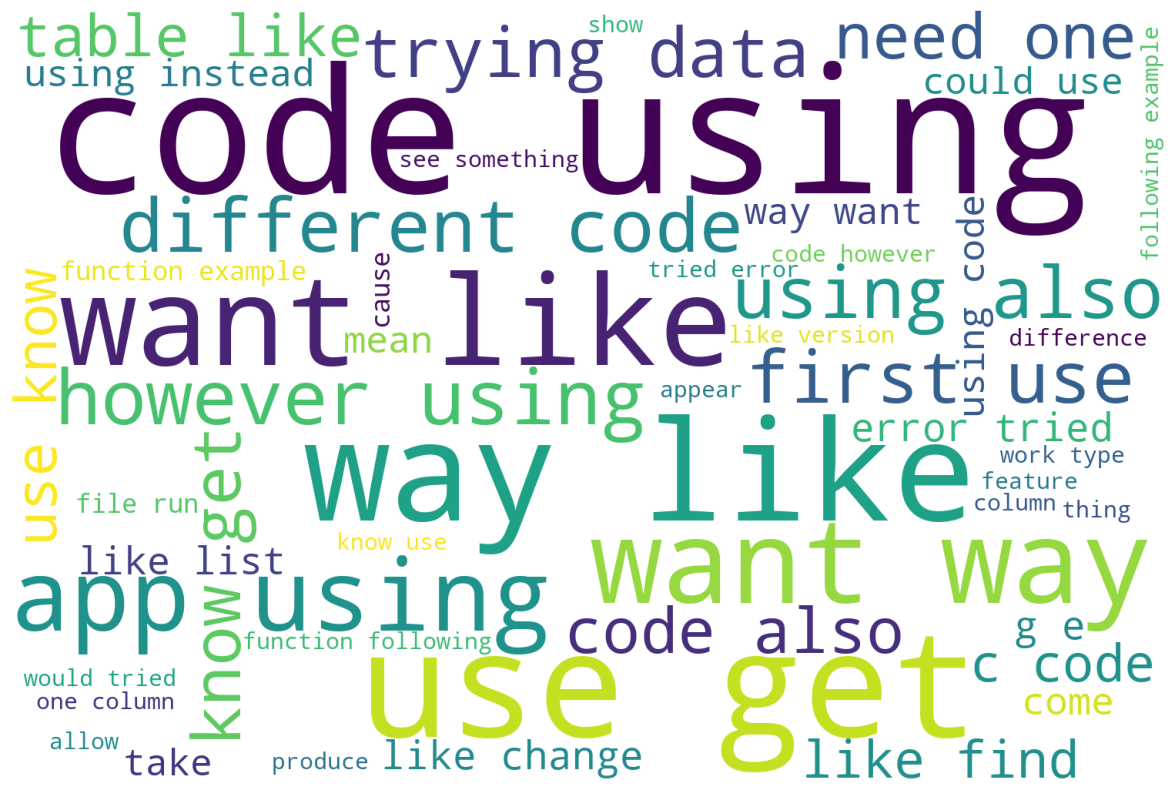

In [125]:
plt.figure(figsize=(15, 10))  # On dimentionne l'image à 15*10 pouces,
                              # donc avec le dpi par défaut de 100, cela donne 1500*1000px

wordcloud_origin = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50,
                      width=1500,  # Dimention en px de l'image à faire entrer 
                      height=1000  # dans la figure plt de 15*10 pouces
                      ).generate(" ".join(corpus))

plt.imshow(wordcloud_origin)
plt.axis("off")
plt.show()

- Corpus traité avec ```process_documents()``` et post traité avec ```post_rare_suppr()``` : 

In [126]:
# On regroupe les tokens de tous les documents dans un pd.series
processed_corpus = data['processed_corpus'].explode()

display_tokens_infos(processed_corpus)

print()

print("Tokens les plus fréquents : ")
display(processed_corpus.value_counts().head(10))

print("Tokens les moins fréquents : ")
display(processed_corpus.value_counts().tail(10))

print("Distribution des présences des tokens : ")
display(processed_corpus.value_counts().describe())

Nombre de tokens : 1317321
Nombre de tokens uniques : 3707
5 premiers tokens : ['rule' 'handle' 'backslash' 'expand' 'answer']

Tokens les plus fréquents : 


processed_corpus
code        25297
error       23379
file        21496
function    18599
value       18382
way         15183
type        14013
datum       13084
example     11790
work        11713
Name: count, dtype: int64

Tokens les moins fréquents : 


processed_corpus
cloudkit       11
marketplace    11
ascending      11
journey        11
subsystem      11
tray           11
dialect        11
snap           11
projectname    11
cropping       11
Name: count, dtype: int64

Distribution des présences des tokens : 


count     3707.000000
mean       355.360399
std       1267.077068
min         11.000000
25%         24.000000
50%         54.000000
75%        184.000000
max      25297.000000
Name: count, dtype: float64

On constate que le vocabulaire (nombre de tokens uniques) a été considérablement réduit dans *processed_corpus*.<br>

- Y a-t-il des mots communs qui apparaissent dans une proportion élevée de documents et qui ne seraient donc pas très différenciants ?

In [127]:
# Seuils en pourcentage à tester
threshold_percentage = [10, 20, 30, 40, 50]

for i in threshold_percentage:

    word_document_count = defaultdict(int)  # defaultdict pour éviter les erreurs s'il s'agit d'une nouvelle clé
    total_documents = len(data)

    # Compter le nombre de documents dans lesquels chaque mot apparaît
    for document in data['processed_corpus']:
        unique_words_in_document = set(document)
        for word in unique_words_in_document:
            word_document_count[word] += 1

    # Trouver les mots qui dépassent le seuil
    common_words_above_threshold = [word for word, count in word_document_count.items() if (count / total_documents) * 100 >= i]

    # Afficher les mots communs qui dépassent le seuil
    print(f"Mots présents dans {i}% des documents : {common_words_above_threshold}")

Mots présents dans 10% des documents : ['example', 'work', 'error', 'file', 'use', 'way', 'type', 'function', 'output', 'time', 'problem', 'code', 'datum', 'value', 'question', 'issue']
Mots présents dans 20% des documents : ['error', 'way', 'code']
Mots présents dans 30% des documents : ['code']
Mots présents dans 40% des documents : []
Mots présents dans 50% des documents : []


On constate qu'il y a peu de mots communs, ce n'est pas avec ces mots que nous parviendrons à réduire encore significativement notre vocabulaire.<br>

<div class="alert alert-info">
Le vocabulaire, bien que très réduit par rapport au corpus d'origine, comporte encore plusieurs milliers de mots. C'est à priori trop à passer dans nos modèles à venir. Cependant, nous n'allons pas les filter davantage pour le moment. La taille du vocabulaire pourra être réduite au moment des vectorisations du corpus (en gardant les mots les plus courants) plus ou moins en fonction des modèles que nous testerons.
</div>

### **Word cloud du corpus après tous les traitements**

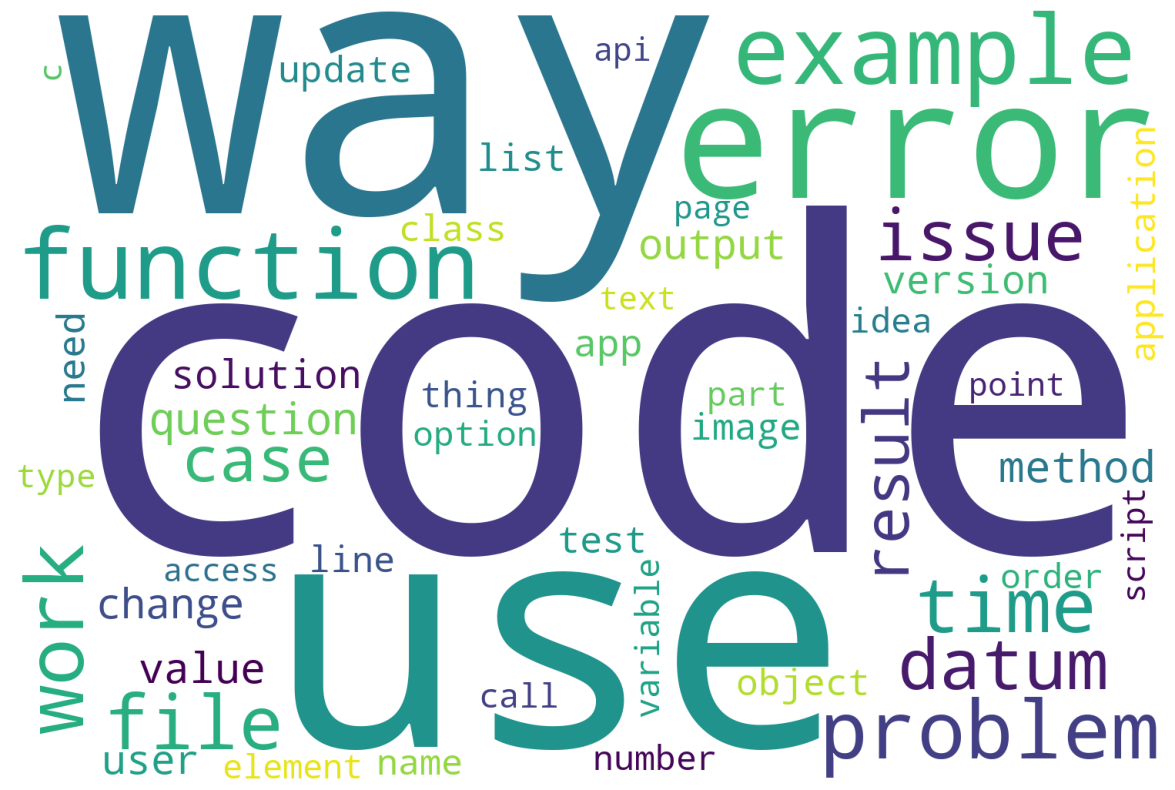

In [128]:
plt.figure(figsize=(15, 10))  # On dimentionne l'image à 15*10 pouces,
                              # donc avec le dpi par défaut de 100, cela donne 1500*1000px

wordcloud_processed = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50,
                      width=1500,  # Dimention en px de l'image à faire entrer 
                      height=1000  # dans la figure plt de 15*10 pouces
                      ).generate(" ".join(processed_corpus))

plt.imshow(wordcloud_processed)
plt.axis("off")
plt.show()

## **Traitement des tags**

- Nous avons vu lors de l'EDA les informations suivantes concernant les tags : 

In [129]:
top_tags = 20

print(f"Les {top_tags} tags les plus présents : \n")
print(all_tags.value_counts().head(top_tags))  # On reprend la variable 'all_tags' provenant de l'EDA
                                               # qui contient donc tous les tags d'origine, sur lesquels ont veut se baser,
                                               # avant suppression des lignes qui ont eu lieu après traitement du corpus.
print("-"*50)
print(f"{len(all_tags)} tags ont été utilisés pour décrire l'ensemble des documents.")
print(f"Il y a {len(all_tags.unique())} tags différents.")
print("-"*50)

Les 20 tags les plus présents : 

tags
python        7035
javascript    4671
c++           3018
c#            2984
reactjs       2492
r             2458
java          2280
typescript    2256
pandas        1664
android       1450
html          1349
flutter       1324
css           1227
node.js       1197
c             1138
sql           1095
dataframe      986
php            955
swift          927
python-3.x     920
Name: count, dtype: int64
--------------------------------------------------
154513 tags ont été utilisés pour décrire l'ensemble des documents.
Il y a 13389 tags différents.
--------------------------------------------------


Il y a plus de 13000 tags uniques. C'est beaucoup trop à passer dans nos modèles à venir avec les moyens techniques dont nous disposons.

### **Regroupement de tags**

- Commençons par regarder si certains tags peuvent être regroupés.<br>

Nous voyons le tag *python-3.x* qui correspond à la dernière version majeure du langage Python (*python* est le tag le plus utilisé).<br>
Sachant que nous cherchons à prédire les tags des futurs messages, préciser qu'il s'agit de la nouvelle version *python-3.x* au lieu de simplement préciser *python* sera de moins en moins nécessaire.<br>
Nous allons donc regrouper *python-3.x* et *python* sous le tag *python*.

- Existe-t-il d'autres cas similaire de numéros de version dans les tags ?

Pour limiter le nombre de tags à traiter, nous allons tester pour les tags les plus courants.

In [130]:
a_tester = 1000
indices_avec_nombres = [mot for mot in all_tags.value_counts().head(a_tester).index if any(char.isdigit() for char in mot)]
print(f"Il y a {len(indices_avec_nombres)} tags contenant des nombres parmi les {a_tester} tags les plus courants : \n")
print(indices_avec_nombres)

Il y a 60 tags contenant des nombres parmi les 1000 tags les plus courants : 

['python-3.x', 'c++20', 'ggplot2', 'vuejs3', 'c++17', '.net-6.0', 'amazon-s3', 'visual-studio-2022', 'c++11', 'amazon-ec2', 'x86-64', 'next.js13', 'x86', 'oauth-2.0', 'laravel-8', 'ecmascript-6', 'nuxtjs3', 'vuejs2', 'java-8', 'apple-m1', 'pyqt5', 'bootstrap-5', '.net-7.0', 'laravel-9', 'c++23', 'asp.net-core-6.0', 'ios16', 'java-17', 'c++14', 'utf-8', 'xcode14', 'winui-3', 'vb6', 'bootstrap-4', 'stm32', 'boto3', 'es6-modules', 'shopware6', 'neo4j', 'd3.js', 'ruby-on-rails-7', 'office365', 'wsl-2', 'jinja2', 'scala-3', 'html5-canvas', 'windows-10', 'visual-studio-2019', 'java-11', '.net-4.8', 'arm64', 'log4j2', 'junit5', '3d', 'ef-core-6.0', 'windows-11', 'es6-promise', 'ieee-754', 'sql-server-2019', 'base64']


Nous trouvons en effet d'autres tags avec des nombres qui semblent correspondre à des numéro de version.<br>
Nous en retenons un certains nombre, que nous allons uniformiser comme suit : 

- python-3.x → python (vu précédemment)
- c++20 → c++
- c++17 → c++
- c++11 → c++
- c++23 → c++
- c++14 → c++
- .net-4.8 → .net
- .net-6.0 → .net
- .net-7.0 → .net
- java-8 → java
- java-17 → java
- java-11 → java
- laravel-8 → laravel
- laravel-9 → laravel
- visual-studio-2019 → visual-studio
- visual-studio-2022 → visual-studio
- scala-3 → scala
- junit5 → junit
- asp.net-core-6.0 → asp.net-core
- xcode14 → xcode
- ruby-on-rails-7 → ruby-on-rails
- pyqt5 → pyqt

- Uniformisation des tags : 

In [131]:
# Création d'un dictionnaire de correspondance
correspondances = {
    'python-3.x': 'python',
    'c++20': 'c++',
    'c++17': 'c++',
    'c++11': 'c++',
    'c++23': 'c++',
    'c++14': 'c++',
    '.net-4.8': '.net',
    '.net-6.0': '.net',
    '.net-7.0': '.net',
    'java-8': 'java',
    'java-17': 'java',
    'java-11': 'java',
    'laravel-8': 'laravel',
    'laravel-9': 'laravel',
    'visual-studio-2019': 'visual-studio',
    'visual-studio-2022': 'visual-studio',
    'scala-3': 'scala',
    'junit5': 'junit',
    'asp.net-core-6.0': 'asp.net-core',
    'xcode14': 'xcode',
    'ruby-on-rails-7': 'ruby-on-rails',
    'pyqt5': 'pyqt'
}

# Définition de la fonction qui va faire les remplacements
def appliquer_correspondances(liste):
    return list(set([correspondances.get(mot, mot) for mot in liste]))  # Je transforme la liste en intension en set
                                                                        # pour supprimer les doublons qui pourraient
                                                                        # être créés au niveau d'un document avec l'uniformisation des tags.
                                                                        # Puis je repasse en liste, qui est le format de sortie souhaité.

# Création d'une nouvelle colonne 'tags_uni' avec les remplacement
data['tags_uni'] = data['tags'].apply(appliquer_correspondances)

154513 tags ont été utilisés pour décrire l'ensemble des documents.
Il y a 13389 tags différents.


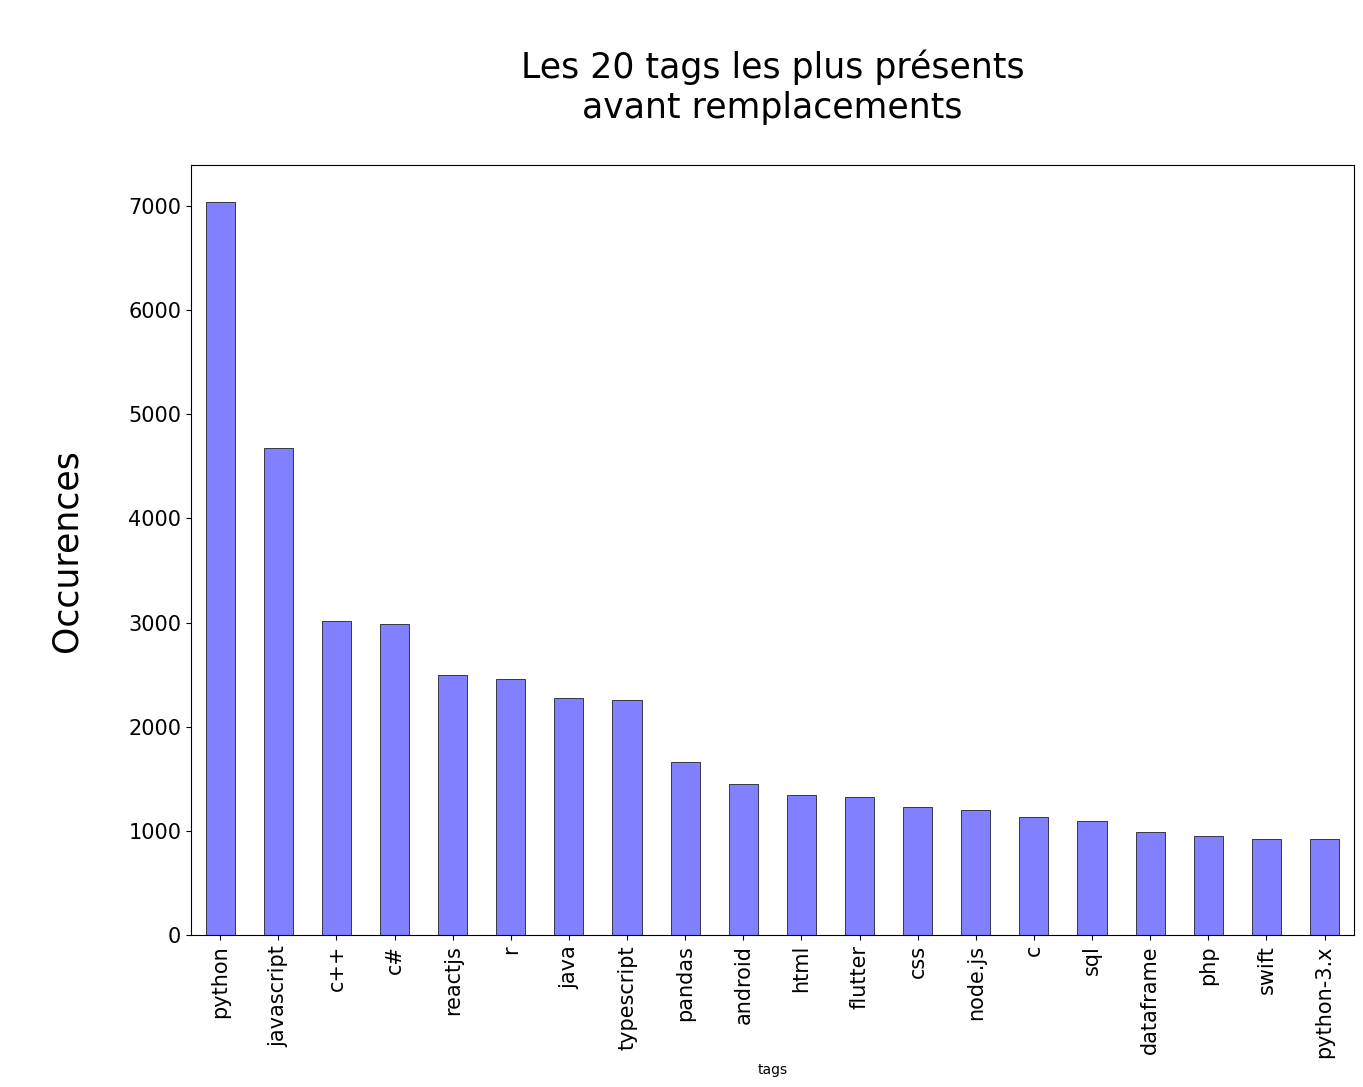

--------------------------------------------------
152720 tags ont été utilisés pour décrire l'ensemble des documents.
Il y a 13367 tags différents.


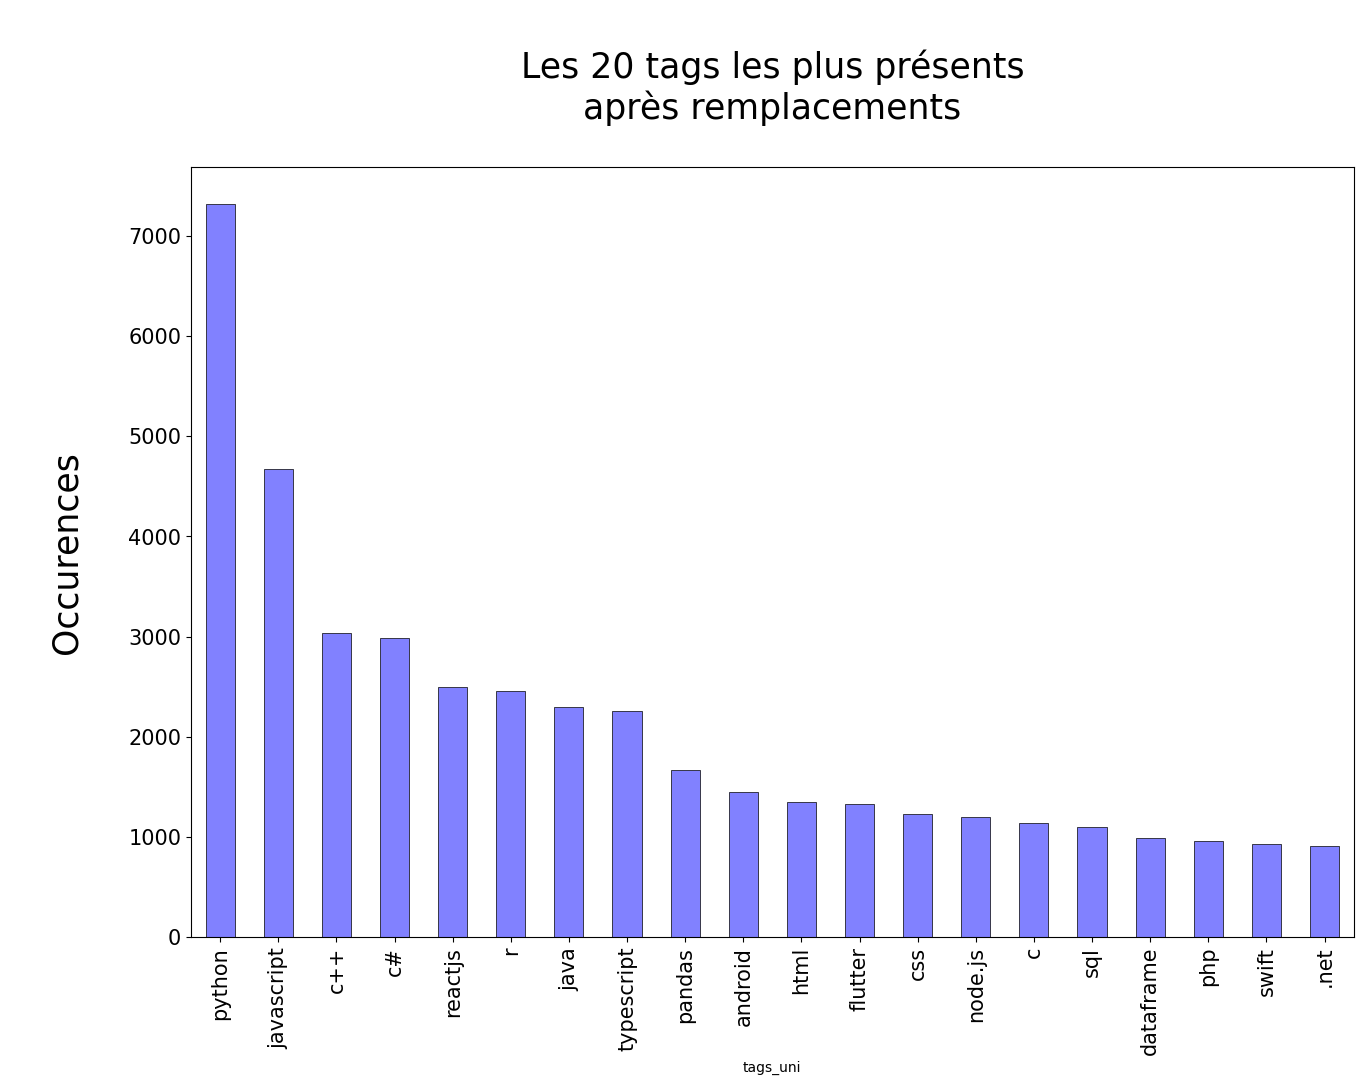

In [132]:
top_tags = 20
# Récup^ération de tous les 'tags_uni'
all_tags_uni = data['tags_uni'].explode()

# Avant remplacements
print(f"{len(all_tags)} tags ont été utilisés pour décrire l'ensemble des documents.")
print(f"Il y a {len(all_tags.unique())} tags différents.")
# Bar plot
plt.figure(figsize=(15, 10))
all_tags.value_counts().head(top_tags).plot.bar(color='#8181FF', edgecolor='black', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("\nOccurences\n", fontsize=25)
plt.title(f"\nLes {top_tags} tags les plus présents\navant remplacements\n", fontsize=25)
plt.show()

print("-"*50)

# Après remplacements
print(f"{len(all_tags_uni)} tags ont été utilisés pour décrire l'ensemble des documents.")  # Il est normal que len(all_tags_uni) < len(all_tags)
                                                                                            # puisque all_tags_uni a été créé après les suppressions de lignes
                                                                                            # faisant suite aux traitements du corpus
print(f"Il y a {len(all_tags_uni.unique())} tags différents.")
# Bar plot
plt.figure(figsize=(15, 10))
all_tags_uni.value_counts().head(top_tags).plot.bar(color='#8181FF', edgecolor='black', linewidth=0.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("\nOccurences\n", fontsize=25)
plt.title(f"\nLes {top_tags} tags les plus présents\naprès remplacements\n", fontsize=25)
plt.show()


- Dans ce top 20 on voit notamment les occurences de *python* et *c++* qui ont augmenté et *.net* qui fait son entrée dans le top.
- Ces regroupements sont intéressants, mais le nombre de tags unique est toujours trop élevé.

### **Sélection des tags les plus fréquents**

- Afin de pouvoir passer nos données dans nos modèles, il nous faut drastiquement réduire la quantité de tags.
- Nous n'allons conserver que les 200 tags les plus utilisés.

In [133]:
# Extraction des 200 tags les plus fréquents dans 'all_tags_uni'
# et conversion en set pour accélérer les traitements ultérieurs
top_200_tags = set(all_tags_uni.value_counts().head(200).index)

# Définition de la fonction qui va réaliser les filtrages
def filtrer_liste(liste):
    return [mot for mot in liste if mot in top_200_tags]

data['tags_top_200'] = data['tags_uni'].apply(filtrer_liste)

- Combien de lignes se retrouvent sans aucun tags suite à ce traitement ?

In [134]:
print(f"Il y a {data.loc[data['tags_top_200'].apply(len) == 0].shape[0]} lignes sans tags suite au traitement précédent.")

Il y a 3492 lignes sans tags suite au traitement précédent.


- Suppression des lignes (donc des documents) qui n'ont plus de tags : 

In [135]:
# Suppression des lignes sans tag (dans tags_top_200) et reset de l'index
data = data.loc[data['tags_top_200'].apply(len) > 0]

- Notre dataframe suite aux différents traitements : 

In [136]:
display(data)

,creationdate,tags,reputation,corpus,tag_in_corpus_before,question_length,tags_number,preprocessed_corpus,processed_corpus,tags_uni,tags_top_200
1,2022-05-08 21:22:05,"[reactjs, firebase, jestjs]",121,"Firebase - Testing with Jest throws error ""INT...",False,476,3,"[test, works, fine, header, error, pages, sign...","[firebase, testing, jest, error, assertion, cl...","[jestjs, firebase, reactjs]","[jestjs, firebase, reactjs]"
2,2022-05-08 21:49:08,"[async-await, concurrency, hacklang]",307,Concurrent block in hacklang Since hack is a s...,True,194,3,"[concurrent, benefit, block, hack, waiting, si...","[block, hack, language, benefit, block, job, w...","[async-await, hacklang, concurrency]","[async-await, concurrency]"
3,2022-05-08 21:49:57,[typescript],1436,Can you set a type for a function in typescrip...,True,747,1,"[required, implement, ide, quickly, thing, lin...","[type, function, typescript, function, type, i...",[typescript],[typescript]
4,2022-05-08 21:51:00,"[expo, google-play-console, google-play-develo...",4346,"Expo EAS Submit, where to store service accoun...",True,553,3,"[required, path, prompted, submitted, somehow,...","[store, service, account, looking, expo, appli...","[google-play-developer-api, expo, google-play-...",[expo]
5,2022-05-08 22:32:53,"[c, struct, memcpy, portability]",645,Reliably and portably store and retrieve objec...,True,1282,4,"[compiled, done, memory, store, area, allocate...","[store, retrieve, structure, type, c, copying,...","[c, portability, struct, memcpy]",[c]
...,...,...,...,...,...,...,...,...,...,...,...
49992,2022-03-21 08:52:43,"[javascript, jquery, jquery-select2]",158,How to know if a select2 has options I don't n...,False,597,3,"[always, someone, thanks, used, changed, ever,...","[option, option, know, option, case, option, o...","[javascript, jquery, jquery-select2]","[javascript, jquery]"
49994,2022-03-21 08:54:03,"[python, matplotlib]",2737,matplotlib: How to plot a closed ring in a rad...,True,874,2,"[pass, follow, gap, polygon, red, output, pres...","[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, python]","[matplotlib, python]"
49997,2022-03-21 09:02:54,[terraform],4200,Which security problem does terraform Checksum...,True,553,1,"[vicious, field, security, problem, intended, ...","[security, problem, terraform, dependency, loc...",[terraform],[terraform]
49998,2022-03-21 13:54:21,"[azure, azurite]",135,Visual studio 2022 with azurite integrated (v3...,True,1037,2,"[thrown, read, incoming, studio, delivered, in...","[studio, creation, blob, container, error, mes...","[azurite, azure]",[azure]


- Combien de document du corpus contiennent les tags dans leur texte après tous nos traitements ?

In [137]:
# Application de la fonction dédiée et création de la colonne "tag_in_corpus_after"
data['tag_in_corpus_after'] = data.apply(lambda row: has_tag_in_corpus(row['tags_top_200'], row['processed_corpus']), axis=1)

# Proportion de documents qui contiennent au moins un tag
proportion_after = data['tag_in_corpus_after'].sum() / len(data)

print(f"La proportion de lignes où au moins un mot de 'tags_top_200' est présent dans 'processed_corpus' est de : {proportion_after:.2%} ({proportion_before:.2%} avant traitements)")

La proportion de lignes où au moins un mot de 'tags_top_200' est présent dans 'processed_corpus' est de : 34.92% (52.72% avant traitements)


- Exemple de document avant et après traitement : 

In [138]:
print("Avant traitement : ")
print(data['corpus'][1])
print("Tags :", data['tags'][1])
print("-"*50)
print("Après traitement : ")
print(data['processed_corpus'][1])
print("Tags :", data['tags_top_200'][1])

Avant traitement : 
Firebase - Testing with Jest throws error "INTERNAL ASSERTION FAILED: Expected a class definition" I am testing my React app with Jest and Enzyme. I use Firebase as well and when I try to write tests for my pages which use a Header component with Firebase signin, I get the following error:
Test suite failed to run

This is my Firebase configuration file:

I am on Firebase 9.8.0.
Are there any ideas what I am missing? The app itself and the authentication flow works fine.

Tags : ['reactjs', 'firebase', 'jestjs']
--------------------------------------------------
Après traitement : 
['firebase', 'testing', 'jest', 'error', 'assertion', 'class', 'definition', 'testing', 'app', 'use', 'firebase', 'test', 'page', 'header', 'component', 'firebase', 'error', 'test', 'suite', 'firebase', 'configuration', 'file', 'firebase', 'idea', 'app', 'authentication', 'flow']
Tags : ['jestjs', 'firebase', 'reactjs']


- Reset de l'index suite aux suppressions de lignes

In [139]:
data.reset_index(inplace=True, drop=True)

## **Suppression des colonnes inutiles**

Lors des traitements, de nombreuses colonnes avaient été crées pour réaliser des vérifications, nous n'en avons désormais plus besoin.

In [140]:
# J'en profite pour renommer les colonnes que l'on conserve
data = data[['processed_corpus', 'tags_top_200']].rename(columns={"processed_corpus": "corpus", "tags_top_200": "tags"})
display(data)

,corpus,tags
0,"[firebase, testing, jest, error, assertion, cl...","[jestjs, firebase, reactjs]"
1,"[block, hack, language, benefit, block, job, w...","[async-await, concurrency]"
2,"[type, function, typescript, function, type, i...",[typescript]
3,"[store, service, account, looking, expo, appli...",[expo]
4,"[store, retrieve, structure, type, c, copying,...",[c]
...,...,...
46493,"[option, option, know, option, case, option, o...","[javascript, jquery]"
46494,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, python]"
46495,"[security, problem, terraform, dependency, loc...",[terraform]
46496,"[studio, creation, blob, container, error, mes...",[azure]


## **Sauvegarde du dataframe dans un fichier**

Pour pouvoir l'utiliser dans d'autres notebooks.

In [141]:
nom_fichier = 'data_clean'
# Export du dataset data
if os.path.isfile(f'{nom_fichier}.pkl') == False:
    with open(f'{nom_fichier}.pkl', 'wb') as fichier:
        pickle.dump(data, fichier)
    print(f"Fichier {nom_fichier}.pkl créé.")
else:
    print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

Fichier data_clean.pkl créé.


- Mesure de la durée d'exécution du notebook : 

In [142]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 04:38
